# Financial Transaction Forensic Project

## Overview of the project

This project aims to identify the whether the transaction is fraud or legitimate from the synthethized data set that introduced simple and subtle frauds usig the hybrid approach of flagging the transcations based on rule approach and then passing those flagged transactions into ML to filter out real fraud and  reduce the false positive flagged from the rule based approach.

##  Approach to the project

### Phase 1
1. Create a synthetic training data set that has simple fraud patterns injected
2. Flagged the fraudulent transactions by fraud type and label it as fraud
3. Create a syhthetic validatoin data set that also has simple fraud patterns injected
4. Preprocess the training data
5. Plot the PCA to see the cluster of legitimate and fraud
6. Train the ML models with created synthetic training data
7. Test the ML model performance using the validation data


Outcome of phase 1 :
We noticed that there is overlap between the fraud and legitimate transaction thus simple model like KNN and Logistic Regression would not be able to differientate it and we tested for KNN and noted it is predicting transactions to be legitimate as most of transaction are legitimate, which mirrors the real data set where fraud count is insignificant thus class imbalance. 
When moved onto robust model (Decision Tree Classifier) as the fraud patterns are simple it memorize the fraud patterns well rather than generalizing on data set to predict. 

So, we decided to move onto phase 2 where we add subtle fraud patterns, contaray to the existing simple frauds

### Phase 2
In phase 2 we tried hybrid approach to

1. Created a synthethic data set that has both simple and subtle frauds patterns injected
2. Preprocess the synthetic data
3. Plot the PCA to see the cluster of legitimate and fraud
4. Train and test the ML models( Decision Tree Classifier and Random Forest) with created synthetic data set
5. Hyperparameter tune the model for model performance optimization
6. Extract the top features abovee 0.05 and run the base and tuned ML using the top features
7. Compare performance metrics of the models

### Phase 3
1. Created a synthetic testing data set that has both simple and subtle fraud patterns injectd
2. Using rule base approach flagged the transactions by fraud type and label it as fraud
3. Pass the flagged as fraud transactions into the selected ML model to reduce the false positive cases.



## Install Faker module

In [1]:
# install the faker module
!pip install Faker

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 108.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


# Phase 1

# Create a simple synthetic data set

### Data Dictionary

- transaction_id : Unique transaction number (integer)
- employee_id : Employee assigned number (integer)
- vendor_name : Name of the vendor (string)
- invoice_number: Invoice number from the vendor: E.g INV-1009 (string)
- transaction_date: Date the transaction occured (datetime)
- amount: The amount cost paid to vendor (integer)
- description: Detailed description of the transaction recorded (string)
- approved_by : Name of personnel approving the transaction (string)

## Inserting fradulent records
### Fraudulent transactions pattern
- Duplicated invoices number ( 5 records)
- amount jus below approval threshold of USD 5000 (3 records)
- suspicious keywords in descrpition ('gift','cash','urgent') (2 records)
- Round suspicious amounts( USD 5000,7500,10000) ( 3 records)
- same vendor used by multiple employees (4 records, 1 overlap with Duplicated Invoice Number record)
- Vendor with amount 5x time of average amount (1 record)

### Step 1 : Creating a synthetic training data set

In [2]:
## Import libries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from faker import Faker

# Instantiate Faker()
fake = Faker()

# Parameters for synthetic data
num_records = 1000
approval_threshold = 5000

# create empty list
data = []

# create seed for reproducibility
Faker.seed(43)
random.seed(43)



# loop to insert values in empty 
for i in range(num_records):
    transaction_id = 1 + i
    employee_id = fake.random_int(min=1000,max=1020)
    vendor_name = fake.company()
    invoice_number = fake.bothify(text='INV-####')
    transaction_date = fake.date_between(start_date= '-90d',end_date='today')
    amount = round(random.uniform(20,10000),2)
    description = fake.sentence(nb_words=5)
    approved_by = fake.name()
    # add to the list
    data.append([transaction_id,employee_id,vendor_name,invoice_number,transaction_date,amount,description,approved_by])

# convert to the data frame
fake_df = pd.DataFrame(data, columns=['transaction_id','employee_id','vendor_name','invoice_number','transaction_date','amount','description','approved_by'])


### Step 1 : Injecting simple fraud pattern

In [3]:
### inject 5 duplicate invoices:
# create seed for reproducibility
Faker.seed(43)
random.seed(43)

fraud_indices_0 = []
for i in range(5):
    # choosing transaction_id number from 0 to 999
    idx = random.randint(0, num_records - 1)
    fraud_indices_0.append(idx)
    # store the index position of the records that will be duplicated
    duplicate_rows = fake_df.iloc[idx].copy()
    # add a transaction_id for these duplicated rows
    duplicate_rows['transaction_id'] = num_records + i + 1
    # add to the data frame
    fake_df = pd.concat([fake_df, pd.DataFrame([duplicate_rows])], ignore_index=True)

fraud_indices_1 = [] 

# inject 3 transactions just under approval threshold
for i in range(3):
    idx = random.randint(0, num_records - 1)
    fraud_indices_1.append(idx)
    fake_df.loc[idx,'amount'] = approval_threshold - 1
    

### inject suspicious keywords records
suspicious_keywords = ['gift', 'cash payment', 'urgent approval']

fraud_indices_2 = [] 
for i in range(2):
    idx = random.randint(0,num_records - 1)
    fake_df.loc[idx,'description'] = fake.sentence(nb_words=3) + '' + suspicious_keywords[i % len(suspicious_keywords)]
    fraud_indices_2.append(idx)


# inject round number values fraud
## round numbers
round_amounts =[5000,7500,10000]

fraud_indices_3 = []
for i in range(len(round_amounts)):
    idx = random.randint(0,num_records-1)
    fraud_indices_3.append(idx)
    fake_df.loc[idx,'amount'] = round_amounts[i]

## Store indices for the same vendor use by different employees
vendor_count=fake_df['vendor_name'].value_counts().reset_index()
vendor_more_than_2=vendor_count.loc[vendor_count['count'] > 2,'vendor_name'].to_list()
fraud_indices_4 = fake_df[fake_df['vendor_name'].isin(vendor_more_than_2)].index.to_list()

# update the choosen vendor's amount with 5 times the average amount
fraud_indices_5 = fraud_indice_5 = fake_df[fake_df['vendor_name']=='Zimmerman-Rice'].index.to_list()
avg_amount = fake_df['amount'].mean()
fake_df.loc[fake_df['vendor_name']=='Zimmerman-Rice', 'amount'] = (avg_amount * 5)

# set a personnel who wont be a approver
original_approval_list = fake_df['approved_by'].unique().tolist()
updated_approval_list = fake_df['approved_by'].unique().tolist()[:-1]

## extract who is not approval person
not_approver = set(original_approval_list) - set(updated_approval_list)



print(f'Duplicated Invoices record indices: {fraud_indices_0} ')
print(f'Transaction under approval threshold records indices: {fraud_indices_1}')
print(f'Suspicious keyword records indices: {fraud_indices_2}')
print(f'Round number amounts records indices: {fraud_indices_3}')
print(f'Vendor used by different employees records indices: {fraud_indices_4}')
print(f'Vendor amount 5x than average amount record index: {fraud_indices_5}')

Duplicated Invoices record indices: [39, 292, 712, 780, 147] 
Transaction under approval threshold records indices: [982, 473, 378]
Suspicious keyword records indices: [687, 715]
Round number amounts records indices: [811, 98, 464]
Vendor used by different employees records indices: [14, 270, 348, 652, 719, 780, 810, 832, 895, 927, 931, 1003]
Vendor amount 5x than average amount record index: [195]


## Step 2 : Set up rules to flag the transactions

In [4]:
# copy the data frame
df = fake_df.copy()

In [5]:
# copy the data frame
df = fake_df.copy()

### flag the duplicates
duplicate_subset = ['vendor_name', 'invoice_number', 'amount']

# instantiate a blank column
df['fraud_type'] = ''
# update the new columns with Duplicate_records string
df.loc[df.duplicated(subset=duplicate_subset, keep=False), 'fraud_type'] = 'Duplicate records'

# ---------------

### flag amount just below approval threshold of USD 5000 (3 records)
approval_threshold = 5000

# set margin for flexibility
margin = 1

# lower bound of amount
lower_bound_amount = approval_threshold - margin
# update the fraud type column wiht string 'Below Approval Threshold'
df.loc[(df['amount'] < approval_threshold ) & (df['amount'] >= lower_bound_amount ),'fraud_type'] = 'Below Approval Threshold'

# ------------

#### flag suspicious keywords in descrpition ('gift','cash','urgent')
suspicious_keywords = ['gift', 'cash payment', 'urgent approval']

# build regex pattern
pattern = '|'.join(suspicious_keywords)
# update the fraud type column with string Suspicious Keywords
df.loc[df['description'].str.contains(pattern,case=False,regex=True), 'fraud_type'] = 'Suspicious Keywords' 

# ---------------------------------

#### flagRound suspicious amounts( USD 5000,7500,10000) 
round_amounts =[5000,7500,10000]
# update the fraud type column with string Round Numbers
df.loc[df['amount'].isin(round_amounts),'fraud_type'] ='Round Numbers'

# ---------------------------------

#### flag same vendor used by multiple employees
vendor_count = df['vendor_name'].value_counts().reset_index()
vendor_more_than_2_list = vendor_count.loc[vendor_count['count'] > 2,'vendor_name'].to_list()
df[df['vendor_name'].isin(vendor_more_than_2_list)]

# update the fraud type column with string Round Numbers
# df.loc[df['vendor_name'].isin(vendor_more_than_2_list), 'fraud_type'] == 'Vendor used by multiple employees'
# mark the rows
df['is_vendor_multi'] = df['vendor_name'].isin(vendor_more_than_2_list).astype(int)

# # if there is populated string in the fraud type column
df.loc[(df['is_vendor_multi'] == 1) & (df['fraud_type'] !='' ), 'fraud_type'] = df['fraud_type']+ ' | ' +'Vendor_used_by_multiple_employees' 

# # if the fraud type column is empty
df.loc[(df['is_vendor_multi'] == 1) & (df['fraud_type'] == ''), 'fraud_type'] = 'Vendor_used_by_multiple_employees' 

# remove the column is_vendor_multi
df = df.drop('is_vendor_multi',axis=1)

# ---------------------------------

#### flag Vendor with amount 5x time of average amount 
avg_amount =df['amount'].mean()
upper_range = avg_amount * 5
lower_range = (df['amount'].nlargest(2).iloc[1])*1.5
# update the fraud type column with string Vendor with high amount
df.loc[(df['amount'] > lower_range) & (df['amount'] <= upper_range), 'fraud_type'] = 'Vendor with high amount'

# ---------------------------------

#### flag Approval person not found 
original_approval_list = df['approved_by'].unique().tolist()
updated_approval_list = df['approved_by'].unique().tolist()[:-1]

## extract who is not approval person
not_approver = set(original_approval_list) - set(updated_approval_list)

# update the fraud type column with string Approval person not found
# df.loc[df['approved_by'].isnot()] 
df.loc[~df['approved_by'].isin(updated_approval_list),'fraud_type'] = 'Approved person not found'

# ---------------------------------
#### cleaning of data and populating a new column

# convert the blank in 'fraud_type' column to null
df['fraud_type'].replace('', np.nan, inplace=True)

# populated the Yes/No in the new column fraud using numpy where if null retur No else Yes
df['fraud'] = np.where(df['fraud_type'].isna(),'No','Yes')

# replace null in fraud_type wih string legitimate_records
df.loc[df['fraud_type'].isna(),'fraud_type'] ='Legitimate_records'


In [6]:
df.head(50)

,transaction_id,employee_id,vendor_name,invoice_number,transaction_date,amount,description,approved_by,fraud_type,fraud
0,1,1001,Horton-Thomas,INV-7517,2025-06-09,404.75,Affect it head system natural sense.,Christopher Rosales,Legitimate_records,No
1,2,1003,Hernandez-Martin,INV-7269,2025-07-14,6968.32,Offer heavy any article.,Sara Phillips,Legitimate_records,No
2,3,1002,"Hanson, Mcneil and Cervantes",INV-0197,2025-06-26,1456.45,Form professional keep call bag.,Shawn Adams,Legitimate_records,No
3,4,1005,"Munoz, Costa and Arnold",INV-1475,2025-06-20,4636.07,List increase similar.,Matthew Russo,Legitimate_records,No
4,5,1004,"Aguirre, Rodriguez and Nichols",INV-7902,2025-04-17,6723.03,Call admit significant.,Phyllis Wilson,Legitimate_records,No
5,6,1017,Green-Webster,INV-7561,2025-06-20,7933.65,Response suggest public.,Timothy Powell,Legitimate_records,No
6,7,1019,"Ortiz, Mcbride and Sanders",INV-0282,2025-06-26,4542.83,Relationship whole prove where.,Cole Robinson,Legitimate_records,No
7,8,1012,Walker-Ellis,INV-0100,2025-06-05,4992.76,Suggest thousand mean measure born generation.,Jerry Myers,Legitimate_records,No
8,9,1007,Rodriguez and Sons,INV-1996,2025-05-05,211.19,Black cost bring fine Mrs.,Brittany Sanchez,Legitimate_records,No
9,10,1007,Davis Group,INV-4175,2025-04-29,4335.24,Act debate wife change.,Jill Sharp,Legitimate_records,No


## Verify the number of records and data type of each columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    1005 non-null   int64  
 1   employee_id       1005 non-null   int64  
 2   vendor_name       1005 non-null   object 
 3   invoice_number    1005 non-null   object 
 4   transaction_date  1005 non-null   object 
 5   amount            1005 non-null   float64
 6   description       1005 non-null   object 
 7   approved_by       1005 non-null   object 
 8   fraud_type        1005 non-null   object 
 9   fraud             1005 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 78.6+ KB


## Step 3 : Create a synthetized dataset for validation

In [8]:
## Import libries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from faker import Faker

# Instantiate Faker()
fake = Faker()

# Parameters for synthetic data
num_records = 1250
approval_threshold = 5000

# create empty list
data = []

# create seed for reproducibility
Faker.seed(45)
random.seed(45)

# -------------# Creating synthetic data set #-----------#
# loop to insert values in empty 
for i in range(num_records):
    transaction_id = 200 + i
    employee_id = fake.random_int(min=1000,max=1020)
    vendor_name = fake.company()
    invoice_number = fake.bothify(text='INV-####')
    transaction_date = fake.date_between(start_date= '-90d',end_date='today')
    amount = round(random.uniform(20,10000),2)
    description = fake.sentence(nb_words=5)
    approved_by = fake.name()
    # add to the list
    data.append([transaction_id,employee_id,vendor_name,invoice_number,transaction_date,amount,description,approved_by])

# convert to the data frame
val_fake_df = pd.DataFrame(data, columns=['transaction_id','employee_id','vendor_name','invoice_number','transaction_date','amount','description','approved_by'])


# -------------# Injecting fraud transaction to data set #-----------#

### inject 5 duplicate invoices:
# create seed for reproducibility

fraud_indices_0 = []
for i in range(4):
    # choosing transaction_id number from 0 to 999
    idx = random.randint(0, num_records - 1)
    fraud_indices_0.append(idx)
    # store the index position of the records that will be duplicated
    duplicate_rows = val_fake_df.iloc[idx].copy()
    # add a transaction_id for these duplicated rows
    duplicate_rows['transaction_id'] = num_records + i + 1
    # add to the data frame
    val_fake_df = pd.concat([val_fake_df, pd.DataFrame([duplicate_rows])], ignore_index=True)

fraud_indices_1 = [] 

# inject 3 transactions just under approval threshold
for i in range(4):
    idx = random.randint(0, num_records - 1)
    fraud_indices_1.append(idx)
    val_fake_df.loc[idx,'amount'] = approval_threshold - 1
    

### inject suspicious keywords records
suspicious_keywords = ['gift', 'cash payment', 'urgent approval']

fraud_indices_2 = [] 
for i in range(3):
    idx = random.randint(0,num_records - 1)
    val_fake_df.loc[idx,'description'] = fake.sentence(nb_words=3) + '' + suspicious_keywords[i % len(suspicious_keywords)]
    fraud_indices_2.append(idx)


# inject round number values fraud
## round numbers
round_amounts =[5000,7500,10000]

fraud_indices_3 = []
for i in range(len(round_amounts)):
    idx = random.randint(0,num_records-1)
    fraud_indices_3.append(idx)
    val_fake_df.loc[idx,'amount'] = round_amounts[i]

## Store indices for the same vendor use by different employees
vendor_count=val_fake_df['vendor_name'].value_counts().reset_index()
vendor_more_than_2=vendor_count.loc[vendor_count['count'] > 2,'vendor_name'].to_list()
fraud_indices_4 = val_fake_df[val_fake_df['vendor_name'].isin(vendor_more_than_2)].index.to_list()

# update the choosen vendor's amount with 5 times the average amount
fraud_indices_5 = val_fake_df[val_fake_df['vendor_name']=='Woods-Craig'].index.to_list()
avg_amount = val_fake_df['amount'].mean()
val_fake_df.loc[val_fake_df['vendor_name']=='Woods-Craig', 'amount'] = (avg_amount * 5)

# set a personnel who wont be a approver
original_approval_list = val_fake_df['approved_by'].unique().tolist()
updated_approval_list = val_fake_df['approved_by'].unique().tolist()[:-1]

## extract who is not approval person
not_approver = set(original_approval_list) - set(updated_approval_list)

print(f'Duplicated Invoices record indices: {fraud_indices_0} ')
print(f'Transaction under approval threshold records indices: {fraud_indices_1}')
print(f'Suspicious keyword records indices: {fraud_indices_2}')
print(f'Round number amounts records indices: {fraud_indices_3}')
print(f'Vendor used by different employees records indices: {fraud_indices_4}')
print(f'Vendor amount 5x than average amount record index: {fraud_indices_5}')



# -------------# Applying rule to flag the transactions  #-----------#
# copy the data frame
df = val_fake_df.copy()

### flag the duplicates
duplicate_subset = ['vendor_name', 'invoice_number', 'amount']

# instantiate a blank column
df['fraud_type'] = ''
# update the new columns with Duplicate_records string
df.loc[df.duplicated(subset=duplicate_subset, keep=False), 'fraud_type'] = 'Duplicate records'

# ---------------

### flag amount just below approval threshold of USD 5000 (3 records)
approval_threshold = 5000

# set margin for flexibility
margin = 1

# lower bound of amount
lower_bound_amount = approval_threshold - margin
# update the fraud type column wiht string 'Below Approval Threshold'
df.loc[(df['amount'] < approval_threshold ) & (df['amount'] >= lower_bound_amount ),'fraud_type'] = 'Below Approval Threshold'

# ------------

#### flag suspicious keywords in descrpition ('gift','cash','urgent')
suspicious_keywords = ['gift', 'cash payment', 'urgent approval']

# build regex pattern
pattern = '|'.join(suspicious_keywords)
# update the fraud type column with string Suspicious Keywords
df.loc[df['description'].str.contains(pattern,case=False,regex=True), 'fraud_type'] = 'Suspicious Keywords' 

# ---------------------------------

#### flagRound suspicious amounts( USD 5000,7500,10000) 
round_amounts =[5000,7500,10000]
# update the fraud type column with string Round Numbers
df.loc[df['amount'].isin(round_amounts),'fraud_type'] ='Round Numbers'

# ---------------------------------

#### flag same vendor used by multiple employees
vendor_count = df['vendor_name'].value_counts().reset_index()
vendor_more_than_2_list = vendor_count.loc[vendor_count['count'] > 2,'vendor_name'].to_list()
df[df['vendor_name'].isin(vendor_more_than_2_list)]

# update the fraud type column with string Round Numbers
# df.loc[df['vendor_name'].isin(vendor_more_than_2_list), 'fraud_type'] == 'Vendor used by multiple employees'
# mark the rows
df['is_vendor_multi'] = df['vendor_name'].isin(vendor_more_than_2_list).astype(int)

# # if there is populated string in the fraud type column
df.loc[(df['is_vendor_multi'] == 1) & (df['fraud_type'] !='' ), 'fraud_type'] = df['fraud_type']+ ' | ' +'Vendor_used_by_multiple_employees' 

# # if the fraud type column is empty
df.loc[(df['is_vendor_multi'] == 1) & (df['fraud_type'] == ''), 'fraud_type'] = 'Vendor_used_by_multiple_employees' 

# remove the column is_vendor_multi
df = df.drop('is_vendor_multi',axis=1)

# ---------------------------------

#### flag Vendor with amount 5x time of average amount 
avg_amount =df['amount'].mean()
upper_range = avg_amount * 5
lower_range = (df['amount'].nlargest(2).iloc[1])*1.5
# update the fraud type column with string Vendor with high amount
df.loc[(df['amount'] > lower_range) & (df['amount'] <= upper_range), 'fraud_type'] = 'Vendor with high amount'

# ---------------------------------

#### flag Approval person not found 
original_approval_list = df['approved_by'].unique().tolist()
updated_approval_list = df['approved_by'].unique().tolist()[:-1]

## extract who is not approval person
not_approver = set(original_approval_list) - set(updated_approval_list)

# update the fraud type column with string Approval person not found
# df.loc[df['approved_by'].isnot()] 
df.loc[~df['approved_by'].isin(updated_approval_list),'fraud_type'] = 'Approved person not found'

# ---------------------------------
#### cleaning of data and populating a new column

# convert the blank in 'fraud_type' column to null
df['fraud_type'].replace('', np.nan, inplace=True)

# populated the Yes/No in the new column fraud using numpy where if null retur No else Yes
df['fraud'] = np.where(df['fraud_type'].isna(),'No','Yes')

# replace null in fraud_type wih string legitimate_records
df.loc[df['fraud_type'].isna(),'fraud_type'] ='Legitimate_records'

validation_df = df.copy()


Duplicated Invoices record indices: [952, 354, 1210, 835] 
Transaction under approval threshold records indices: [135, 881, 413, 585]
Suspicious keyword records indices: [659, 821, 1163]
Round number amounts records indices: [154, 535, 817]
Vendor used by different employees records indices: [33, 44, 195, 460, 465, 479, 771, 805, 958, 1028, 1210, 1252]
Vendor amount 5x than average amount record index: [962]


In [9]:
validation_df.head(15)

,transaction_id,employee_id,vendor_name,invoice_number,transaction_date,amount,description,approved_by,fraud_type,fraud
0,200,1008,Freeman-Miller,INV-5017,2025-04-17,2733.32,Space what talk power.,Andrea Nelson,Legitimate_records,No
1,201,1004,Riddle Ltd,INV-6196,2025-04-29,4890.52,Type common edge.,Tonya Davis,Legitimate_records,No
2,202,1002,Potter LLC,INV-6889,2025-06-28,837.16,Or art travel treatment.,Mark Smith,Legitimate_records,No
3,203,1015,"Hanson, Carter and Perry",INV-6297,2025-06-05,3400.56,His think partner ahead teach probably.,Donna Turner,Legitimate_records,No
4,204,1005,Dean Inc,INV-6109,2025-07-08,741.89,People lawyer customer establish drug.,Tiffany Walker,Legitimate_records,No
5,205,1000,Gay PLC,INV-4712,2025-06-10,130.14,Thus ask car.,Lance Miller,Legitimate_records,No
6,206,1014,Santos-Ramirez,INV-6628,2025-07-05,2852.83,Fly political will.,Frank Kim,Legitimate_records,No
7,207,1018,Hess Group,INV-8806,2025-06-09,1194.71,Prepare onto arm training director.,Anthony Howell,Legitimate_records,No
8,208,1011,"Delgado, Li and David",INV-8690,2025-06-20,3124.16,Yet leg tonight not history.,Amy Cox,Legitimate_records,No
9,209,1008,Monroe and Sons,INV-6530,2025-05-23,7439.84,Prove option simply.,Kevin Garcia,Legitimate_records,No


## Step 4 : Preprocessing the data for modeling

In [10]:
# import relevant features
import datetime
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## --------------------# For the test data #-----------------##
# copy the data frame
df_1= df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
df_1['invoice_number'] = df_1['invoice_number'].str.extract(r'(\d+)')
df_1['invoice_number'] = df_1['invoice_number'].astype(int)

# extract date,month,year from the transaction_date and drop the transactio_date
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

df_1['year'] = df_1['transaction_date'].dt.year
df_1['month'] = df_1['transaction_date'].dt.month
df_1['day'] = df_1['transaction_date'].dt.year

df_1.drop('transaction_date',axis=1,inplace=True)


## --------------------# For the validation data #-----------------##
# copy the data frame
validation_df_1= validation_df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
validation_df_1['invoice_number'] = validation_df_1['invoice_number'].str.extract(r'(\d+)')
validation_df_1['invoice_number'] = validation_df_1['invoice_number'].astype(int)

# extract date,month,year from the transaction_date and drop the transactio_date
validation_df_1['transaction_date'] = pd.to_datetime(validation_df_1['transaction_date'])

validation_df_1['year'] = validation_df_1['transaction_date'].dt.year
validation_df_1['month'] = validation_df_1['transaction_date'].dt.month
validation_df_1['day'] = validation_df_1['transaction_date'].dt.year

validation_df_1.drop('transaction_date',axis=1,inplace=True)


# split features by type
num_features =['transaction_id','employee_id','invoice_number','amount','year','month','day']
cat_features = ['vendor_name','description','approved_by']

# Features and target for train data
X_train = df_1[num_features + cat_features]
y_train = df_1['fraud']

# Features and target for test data
X_test = validation_df_1[num_features + cat_features]
y_test = validation_df_1['fraud']


# Preprocessing pipeline
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

cat_pipeline = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='ignore'))])

preprocessor =ColumnTransformer([('num',num_pipeline, num_features),('cat',cat_pipeline,cat_features)])

## Step 5 Running PCA to see the clusters on the simple synthetic data

There is overlap between the legitimate and fraud cases so simple model like KNN that takes the most of its neighbours into account and logistic that draw a line to separate the clusters they would failed. So I plan to move on with the more complex models of CART.

In [11]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.datasets import make_classification

## rebuild the pipe line for feature processing

# numeric scale + PCA for 2D
numeric_pipeline= Pipeline([('scale',StandardScaler()),('pca',PCA(n_components=2))])

# category encode + TruncatedSDV
category_pipeline =Pipeline([('encode',OneHotEncoder(handle_unknown='ignore',drop='first')),('tsdv',TruncatedSVD(n_components=2))])

# combined with column transformer
preprocessor_pca = ColumnTransformer([('num',numeric_pipeline,num_features),('cat',category_pipeline,cat_features)])

# fit and transform
x_processed = preprocessor_pca.fit_transform(X_train)


# numeric scale + PCA for 3D
numeric_pipeline= Pipeline([('scale',StandardScaler()),('pca',PCA(n_components=3))])

# category encode + TruncatedSDV
category_pipeline =Pipeline([('encode',OneHotEncoder(handle_unknown='ignore',drop='first')),('tsdv',TruncatedSVD(n_components=6))])

# combined with column transformer
preprocessor_pca = ColumnTransformer([('num',numeric_pipeline,num_features),('cat',category_pipeline,cat_features)])

# fit and transform
x_processed_1 = preprocessor_pca.fit_transform(X_train)



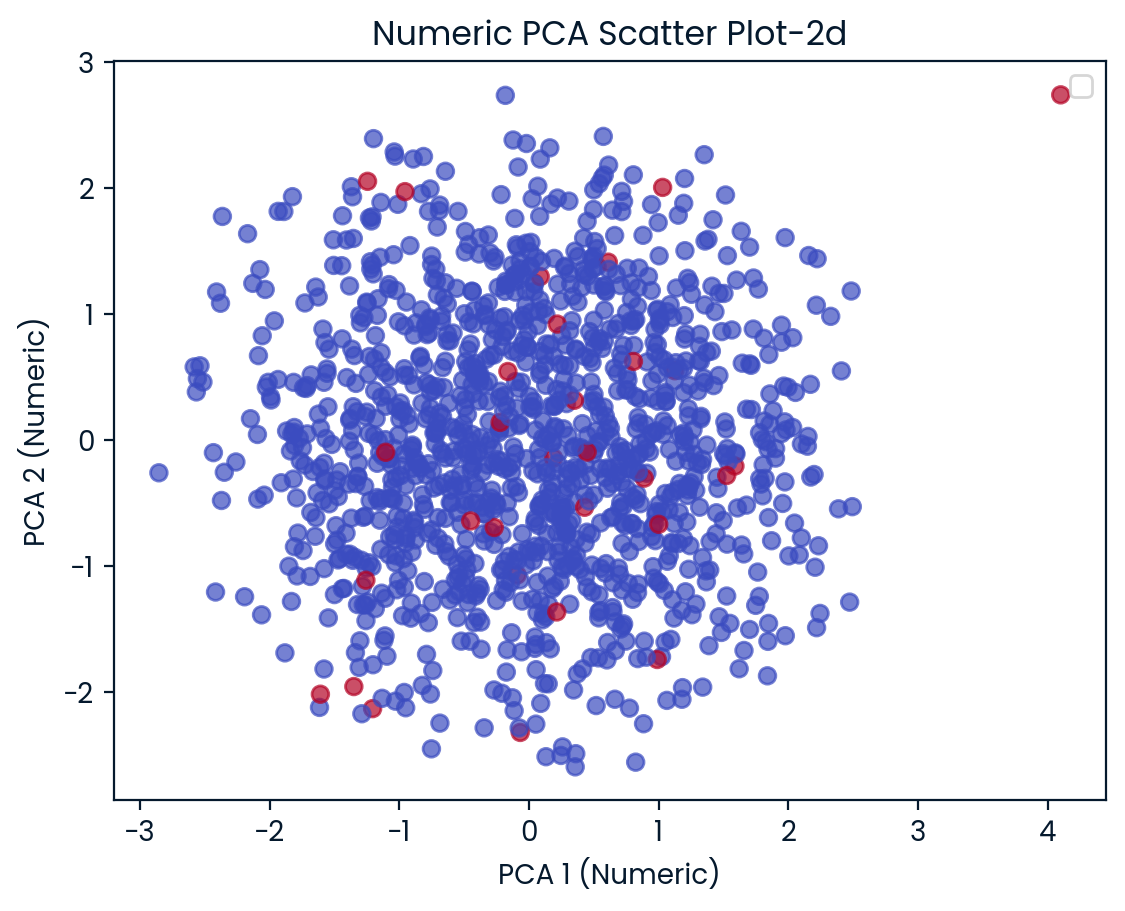

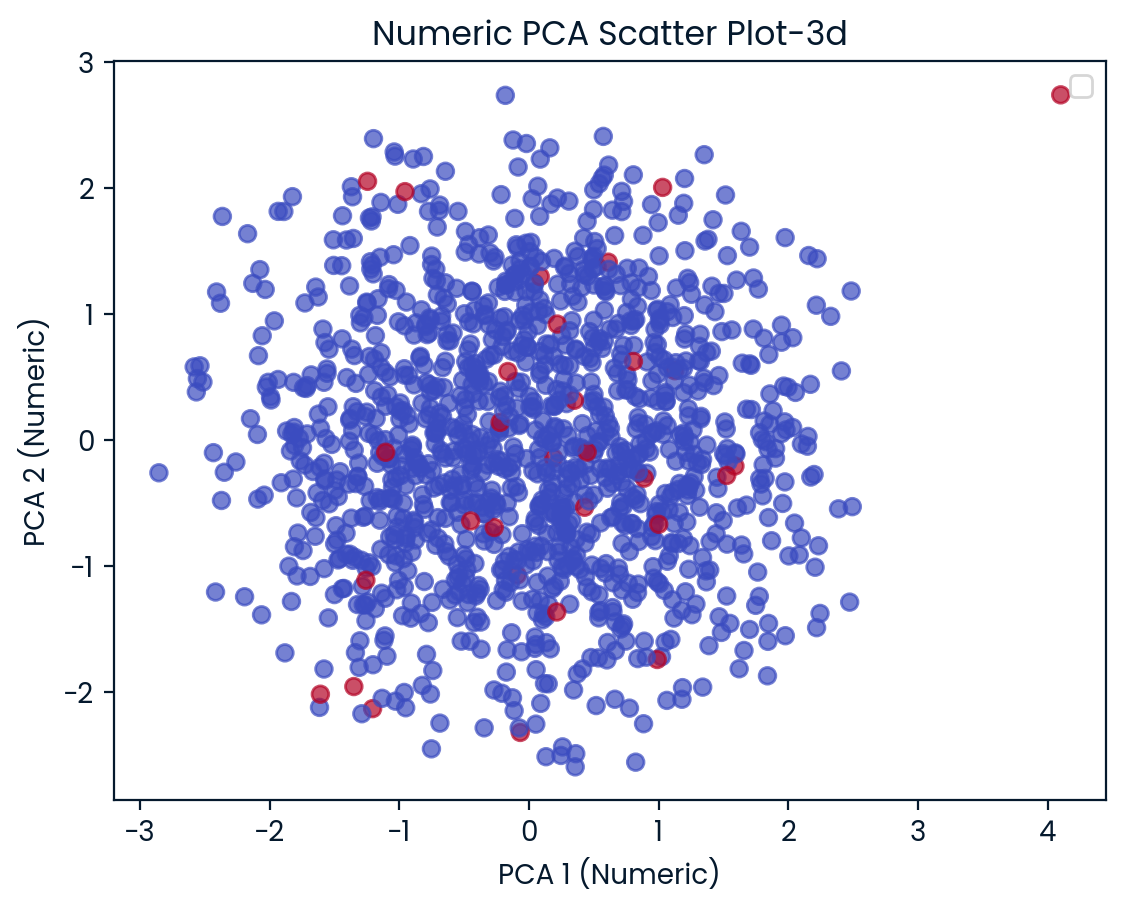

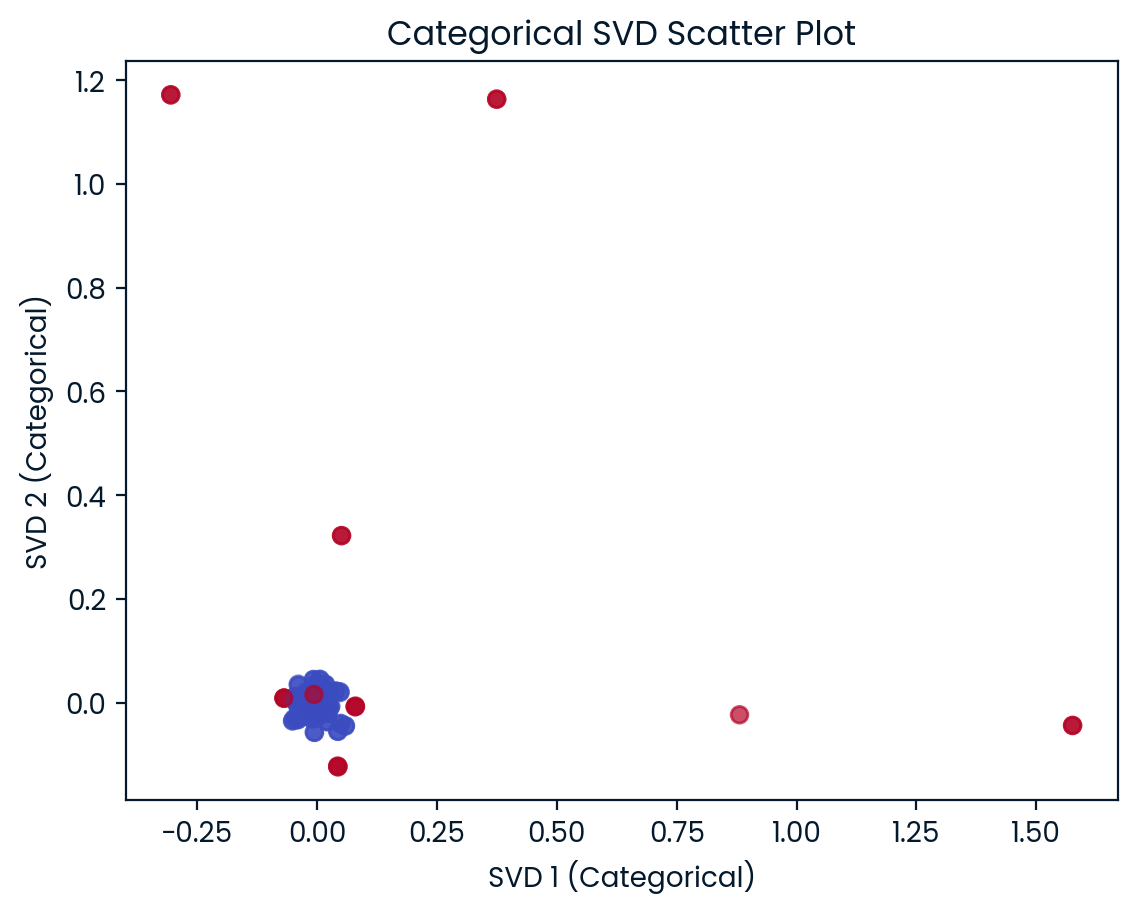

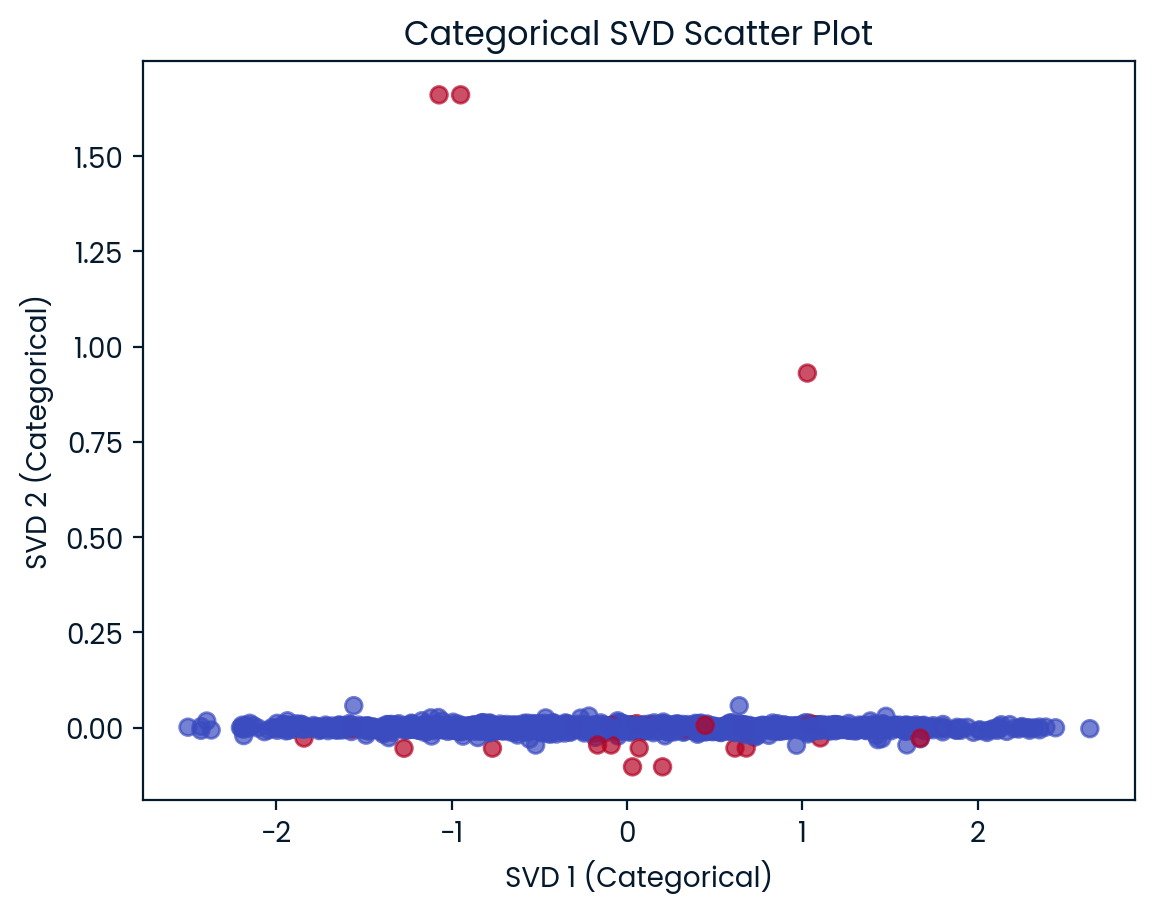

In [12]:
# Plot the 2D numeric PCA
plt.scatter(x_processed[:, 0], x_processed[:, 1], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('PCA 1 (Numeric)')
plt.ylabel('PCA 2 (Numeric)')
plt.title('Numeric PCA Scatter Plot-2d')
plt.legend()
plt.show()

# Plot the 3D numeric PCA
plt.scatter(x_processed_1[:, 0], x_processed_1[:, 1], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('PCA 1 (Numeric)')
plt.ylabel('PCA 2 (Numeric)')
plt.title('Numeric PCA Scatter Plot-3d')
plt.legend()
plt.show()

#  plot SVD 2D
plt.scatter(x_processed[:, 2], x_processed[:, 3], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('SVD 1 (Categorical)')
plt.ylabel('SVD 2 (Categorical)')
plt.title('Categorical SVD Scatter Plot')
plt.show()

#  plot SVD 3D
plt.scatter(x_processed_1[:, 2], x_processed_1[:, 3], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('SVD 1 (Categorical)')
plt.ylabel('SVD 2 (Categorical)')
plt.title('Categorical SVD Scatter Plot')
plt.show()



## Step 6 & 7 : Train and test the ML models 

### KNN 

Due to the class imbalance in traning data where the fraud data made up only 1.39% of the total data, as KNN doesnt have the class weight it is futile to apply this model in this testing where our main focus is on the fraud cases not legitimate cases.

Similar score on train and test data tells that rather than overfitting (where train_score > test_score) model is only learning the majority class pattern which is legitimate; so our focus of fraud is not considered by model.


In [13]:
# Connect pipeline to the model for KNeighborsClassifier
pipe_knn = Pipeline([('prep', preprocessor), ('model', KNeighborsClassifier())])

pipe_knn.fit(X_train,y_train)
print(f'KNN training score before tuned:{pipe_knn.score(X_train,y_train)}')
print(f'KNN testing score before tuned:{pipe_knn.score(X_test,y_test)}','\n')

KNN training score before tuned:0.9784688995215312
KNN testing score before tuned:0.9784688995215312 



###  Decision Tree Classifier

Decision Tree untuned training score 1.0
Decision Tree untuned test score 1.0 



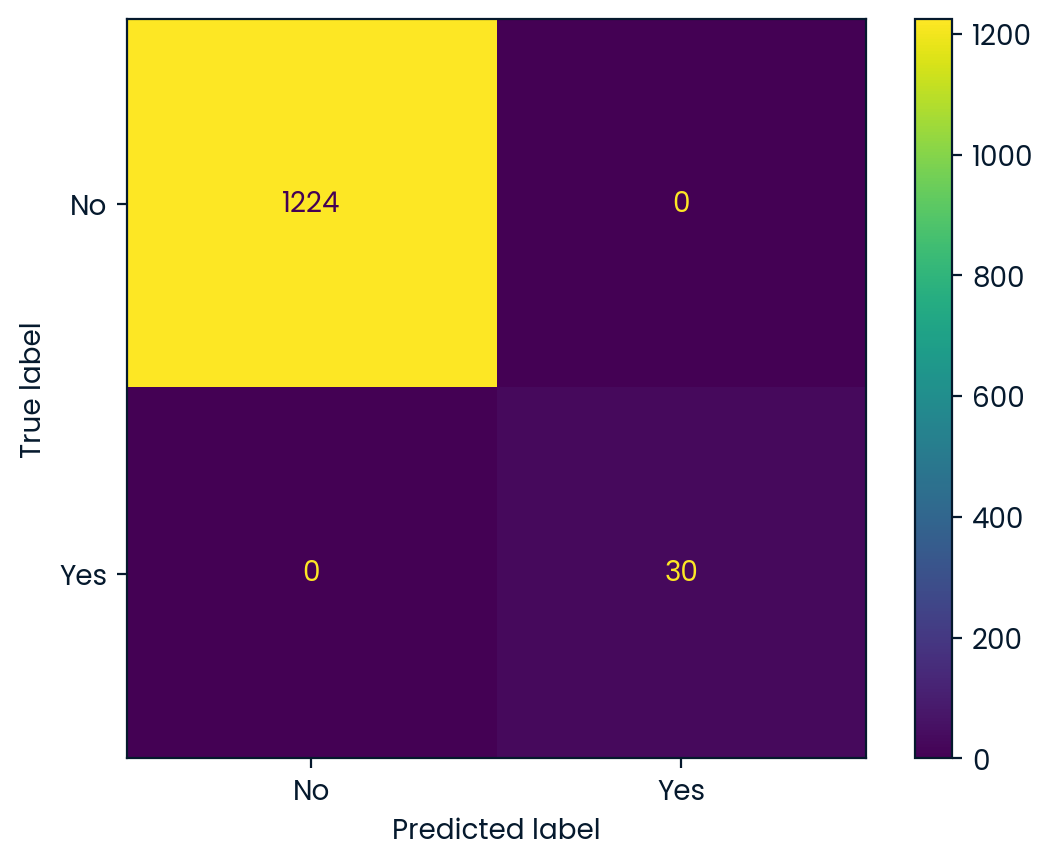

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      1224
         Yes       1.00      1.00      1.00        30

    accuracy                           1.00      1254
   macro avg       1.00      1.00      1.00      1254
weighted avg       1.00      1.00      1.00      1254

CV train accuracy mean:0.9449752988047809
Train accuracy 1.0
Test accuracy 1.0
Generalization gap= 0.0


In [14]:
# Connect pipeline to the model for Decision Tree
pipe_dtc = Pipeline([('pipe', preprocessor), ('model', DecisionTreeClassifier(random_state=42,class_weight='balanced'))])

# fit to the raw model
base_dtc_model = pipe_dtc.fit(X_train, y_train)

print(f'Decision Tree untuned training score {pipe_dtc.score(X_train, y_train)}')
print(f'Decision Tree untuned test score {pipe_dtc.score(X_test, y_test)}','\n')

# predict
base_dtc_model_y_pred =base_dtc_model.predict(X_test)

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, base_dtc_model_y_pred)
plt.show()

# classification report
print(classification_report(y_test, base_dtc_model_y_pred ))

# evaluate the cross validated performance on training data
cv_scores = cross_val_score(base_dtc_model, X_train,y_train,cv=5, scoring='accuracy')

# train accuracy
train_accuracy = base_dtc_model.score(X_train,y_train)

# test accuracy
test_accuracy =base_dtc_model.score(X_test,y_test)

# print the results
print(f'CV train accuracy mean:{np.mean(cv_scores)}')
print(f'Train accuracy {train_accuracy}')
print(f'Test accuracy {test_accuracy}')
print(f'Generalization gap= {train_accuracy-test_accuracy}')



### Random Forest Classifier

Random Tree Classifer untuned training score 1.0
Random Tree Classifer untuned test score 1.0 



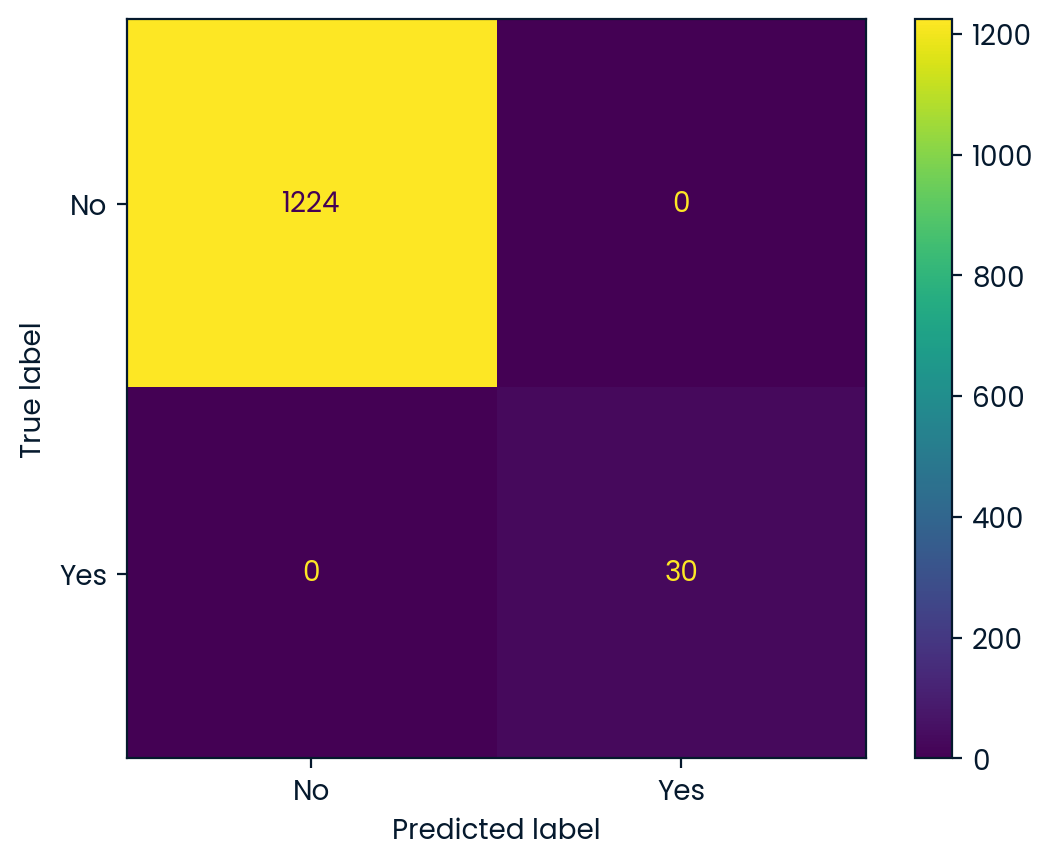

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      1224
         Yes       1.00      1.00      1.00        30

    accuracy                           1.00      1254
   macro avg       1.00      1.00      1.00      1254
weighted avg       1.00      1.00      1.00      1254

CV train accuracy mean:0.9800701195219123
Train accuracy 1.0
Test accuracy 1.0
Generalization gap= 0.0


In [15]:
pipe_rfc = Pipeline([('pipe', preprocessor), 
                     ('model', RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'))])

# fit to the raw model
base_rfc_model = pipe_rfc.fit(X_train, y_train)

print(f'Random Tree Classifer untuned training score {pipe_rfc.score(X_train, y_train)}')
print(f'Random Tree Classifer untuned test score {pipe_rfc.score(X_test, y_test)}','\n')

# predict
base_rfc_model_y_pred =base_rfc_model.predict(X_test)

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, base_rfc_model_y_pred)
plt.show()

# classification report
print(classification_report(y_test, base_rfc_model_y_pred ))


# evaluate the cross validated performance on training data
cv_scores = cross_val_score(base_rfc_model, X_train,y_train,cv=5, scoring='accuracy')

# train accuracy
train_accuracy = base_rfc_model.score(X_train,y_train)

# test accuracy
test_accuracy =base_rfc_model.score(X_test,y_test)

# print the results
print(f'CV train accuracy mean:{np.mean(cv_scores)}')
print(f'Train accuracy {train_accuracy}')
print(f'Test accuracy {test_accuracy}')
print(f'Generalization gap= {train_accuracy-test_accuracy}')


Duplicated Invoices record indices: [952, 354, 1210, 835] 
Transaction under approval threshold records indices: [135, 881, 413, 585]
Suspicious keyword records indices: [659, 821, 1163]
Round number amounts records indices: [154, 535, 817]
Vendor used by different employees records indices: [33, 44, 195, 460, 465, 479, 771, 805, 958, 1028, 1210, 1252]
Vendor amount 5x than average amount record index: [962]
Decision Tree untuned training score 1.0
Decision Tree untuned test score 1.0 



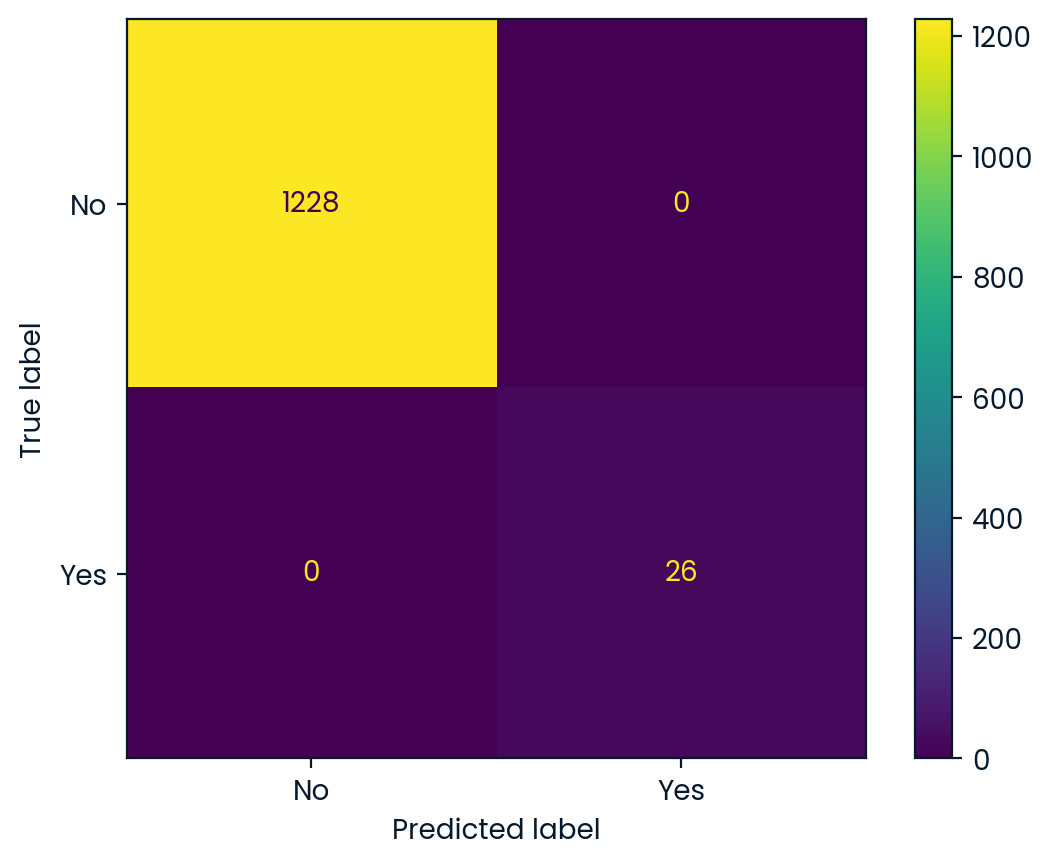

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      1228
         Yes       1.00      1.00      1.00        26

    accuracy                           1.00      1254
   macro avg       1.00      1.00      1.00      1254
weighted avg       1.00      1.00      1.00      1254

1254
1254
CV train accuracy mean:0.9689083665338647


In [16]:
## Import libries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from faker import Faker

# Instantiate Faker()
fake = Faker()

# Parameters for synthetic data
num_records = 1250
approval_threshold = 5000

# create empty list
data = []

# create seed for reproducibility
Faker.seed(45)
random.seed(45)

# -------------# Creating synthetic data set #-----------#
# loop to insert values in empty 
for i in range(num_records):
    transaction_id = 200 + i
    employee_id = fake.random_int(min=1000,max=1020)
    vendor_name = fake.company()
    invoice_number = fake.bothify(text='INV-####')
    transaction_date = fake.date_between(start_date= '-90d',end_date='today')
    amount = round(random.uniform(20,10000),2)
    description = fake.sentence(nb_words=5)
    approved_by = fake.name()
    # add to the list
    data.append([transaction_id,employee_id,vendor_name,invoice_number,transaction_date,amount,description,approved_by])

# convert to the data frame
val_fake_df = pd.DataFrame(data, columns=['transaction_id','employee_id','vendor_name','invoice_number','transaction_date','amount','description','approved_by'])


# -------------# Injecting fraud transaction to data set #-----------#

### inject 5 duplicate invoices:
# create seed for reproducibility

fraud_indices_0 = []
for i in range(4):
    # choosing transaction_id number from 0 to 999
    idx = random.randint(0, num_records - 1)
    fraud_indices_0.append(idx)
    # store the index position of the records that will be duplicated
    duplicate_rows = val_fake_df.iloc[idx].copy()
    # add a transaction_id for these duplicated rows
    duplicate_rows['transaction_id'] = num_records + i + 1
    # add to the data frame
    val_fake_df = pd.concat([val_fake_df, pd.DataFrame([duplicate_rows])], ignore_index=True)

fraud_indices_1 = [] 

# inject 3 transactions just under approval threshold
for i in range(4):
    idx = random.randint(0, num_records - 1)
    fraud_indices_1.append(idx)
    val_fake_df.loc[idx,'amount'] = approval_threshold - 1
    

### inject suspicious keywords records
suspicious_keywords = ['gift', 'cash payment', 'urgent approval']

fraud_indices_2 = [] 
for i in range(3):
    idx = random.randint(0,num_records - 1)
    val_fake_df.loc[idx,'description'] = fake.sentence(nb_words=3) + '' + suspicious_keywords[i % len(suspicious_keywords)]
    fraud_indices_2.append(idx)


# inject round number values fraud
## round numbers
# round_amounts =[5000,7500,10000]

# fraud_indices_3 = []
# for i in range(len(round_amounts)):
#     idx = random.randint(0,num_records-1)
#     fraud_indices_3.append(idx)
#     val_fake_df.loc[idx,'amount'] = round_amounts[i]

## Store indices for the same vendor use by different employees
vendor_count=val_fake_df['vendor_name'].value_counts().reset_index()
vendor_more_than_2=vendor_count.loc[vendor_count['count'] > 2,'vendor_name'].to_list()
fraud_indices_4 = val_fake_df[val_fake_df['vendor_name'].isin(vendor_more_than_2)].index.to_list()

# # update the choosen vendor's amount with 5 times the average amount
# fraud_indices_5 = val_fake_df[val_fake_df['vendor_name']=='Woods-Craig'].index.to_list()
# avg_amount = val_fake_df['amount'].mean()
# val_fake_df.loc[val_fake_df['vendor_name']=='Woods-Craig', 'amount'] = (avg_amount * 5)

# set a personnel who wont be a approver
original_approval_list = val_fake_df['approved_by'].unique().tolist()
updated_approval_list = val_fake_df['approved_by'].unique().tolist()[:-1]

## extract who is not approval person
not_approver = set(original_approval_list) - set(updated_approval_list)

print(f'Duplicated Invoices record indices: {fraud_indices_0} ')
print(f'Transaction under approval threshold records indices: {fraud_indices_1}')
print(f'Suspicious keyword records indices: {fraud_indices_2}')
print(f'Round number amounts records indices: {fraud_indices_3}')
print(f'Vendor used by different employees records indices: {fraud_indices_4}')
print(f'Vendor amount 5x than average amount record index: {fraud_indices_5}')



# -------------# Applying rule to flag the transactions  #-----------#
# copy the data frame
df = val_fake_df.copy()

### flag the duplicates
duplicate_subset = ['vendor_name', 'invoice_number', 'amount']

# instantiate a blank column
df['fraud_type'] = ''
# update the new columns with Duplicate_records string
df.loc[df.duplicated(subset=duplicate_subset, keep=False), 'fraud_type'] = 'Duplicate records'

# ---------------

### flag amount just below approval threshold of USD 5000 (3 records)
approval_threshold = 5000

# set margin for flexibility
margin = 1

# lower bound of amount
lower_bound_amount = approval_threshold - margin
# update the fraud type column wiht string 'Below Approval Threshold'
df.loc[(df['amount'] < approval_threshold ) & (df['amount'] >= lower_bound_amount ),'fraud_type'] = 'Below Approval Threshold'

# ------------

#### flag suspicious keywords in descrpition ('gift','cash','urgent')
suspicious_keywords = ['gift', 'cash payment', 'urgent approval']

# build regex pattern
pattern = '|'.join(suspicious_keywords)
# update the fraud type column with string Suspicious Keywords
df.loc[df['description'].str.contains(pattern,case=False,regex=True), 'fraud_type'] = 'Suspicious Keywords' 

# ---------------------------------

#### flagRound suspicious amounts( USD 5000,7500,10000) 
round_amounts =[5000,7500,10000]
# update the fraud type column with string Round Numbers
df.loc[df['amount'].isin(round_amounts),'fraud_type'] ='Round Numbers'

# ---------------------------------

#### flag same vendor used by multiple employees
vendor_count = df['vendor_name'].value_counts().reset_index()
vendor_more_than_2_list = vendor_count.loc[vendor_count['count'] > 2,'vendor_name'].to_list()
df[df['vendor_name'].isin(vendor_more_than_2_list)]

# update the fraud type column with string Round Numbers
# df.loc[df['vendor_name'].isin(vendor_more_than_2_list), 'fraud_type'] == 'Vendor used by multiple employees'
# mark the rows
df['is_vendor_multi'] = df['vendor_name'].isin(vendor_more_than_2_list).astype(int)

# # if there is populated string in the fraud type column
df.loc[(df['is_vendor_multi'] == 1) & (df['fraud_type'] !='' ), 'fraud_type'] = df['fraud_type']+ ' | ' +'Vendor_used_by_multiple_employees' 

# # if the fraud type column is empty
df.loc[(df['is_vendor_multi'] == 1) & (df['fraud_type'] == ''), 'fraud_type'] = 'Vendor_used_by_multiple_employees' 

# remove the column is_vendor_multi
df = df.drop('is_vendor_multi',axis=1)

# ---------------------------------

#### flag Vendor with amount 5x time of average amount 
avg_amount =df['amount'].mean()
upper_range = avg_amount * 5
lower_range = (df['amount'].nlargest(2).iloc[1])*1.5
# update the fraud type column with string Vendor with high amount
df.loc[(df['amount'] > lower_range) & (df['amount'] <= upper_range), 'fraud_type'] = 'Vendor with high amount'

# ---------------------------------

#### flag Approval person not found 
original_approval_list = df['approved_by'].unique().tolist()
updated_approval_list = df['approved_by'].unique().tolist()[:-1]

## extract who is not approval person
not_approver = set(original_approval_list) - set(updated_approval_list)

# update the fraud type column with string Approval person not found
# df.loc[df['approved_by'].isnot()] 
df.loc[~df['approved_by'].isin(updated_approval_list),'fraud_type'] = 'Approved person not found'

# ---------------------------------
#### cleaning of data and populating a new column

# convert the blank in 'fraud_type' column to null
df['fraud_type'].replace('', np.nan, inplace=True)

# populated the Yes/No in the new column fraud using numpy where if null retur No else Yes
df['fraud'] = np.where(df['fraud_type'].isna(),'No','Yes')

# replace null in fraud_type wih string legitimate_records
df.loc[df['fraud_type'].isna(),'fraud_type'] ='Legitimate_records'

validation_df = df.copy()


# import relevant features
import datetime
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## --------------------# For the test data #-----------------##
# copy the data frame
df_1= df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
df_1['invoice_number'] = df_1['invoice_number'].str.extract(r'(\d+)')
df_1['invoice_number'] = df_1['invoice_number'].astype(int)

# extract date,month,year from the transaction_date and drop the transactio_date
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

df_1['year'] = df_1['transaction_date'].dt.year
df_1['month'] = df_1['transaction_date'].dt.month
df_1['day'] = df_1['transaction_date'].dt.year

df_1.drop('transaction_date',axis=1,inplace=True)


## --------------------# For the validation data #-----------------##
# copy the data frame
validation_df_1= validation_df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
validation_df_1['invoice_number'] = validation_df_1['invoice_number'].str.extract(r'(\d+)')
validation_df_1['invoice_number'] = validation_df_1['invoice_number'].astype(int)

# extract date,month,year from the transaction_date and drop the transactio_date
validation_df_1['transaction_date'] = pd.to_datetime(validation_df_1['transaction_date'])

validation_df_1['year'] = validation_df_1['transaction_date'].dt.year
validation_df_1['month'] = validation_df_1['transaction_date'].dt.month
validation_df_1['day'] = validation_df_1['transaction_date'].dt.year

validation_df_1.drop('transaction_date',axis=1,inplace=True)


# split features by type
num_features =['employee_id','amount','year','month','day']
cat_features = ['vendor_name','description','approved_by']

# Features and target for train data
X_train = df_1[num_features + cat_features]
y_train = df_1['fraud']

# Features and target for test data
X_test = validation_df_1[num_features + cat_features]
y_test = validation_df_1['fraud']


# Preprocessing pipeline
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

cat_pipeline = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='ignore'))])

preprocessor =ColumnTransformer([('num',num_pipeline, num_features),('cat',cat_pipeline,cat_features)])


# Connect pipeline to the model for Decision Tree
pipe_dtc = Pipeline([('pipe', preprocessor), ('model', DecisionTreeClassifier(random_state=42,class_weight='balanced'))])

# fit to the raw model
base_dtc_model = pipe_dtc.fit(X_train, y_train)

print(f'Decision Tree untuned training score {pipe_dtc.score(X_train, y_train)}')
print(f'Decision Tree untuned test score {pipe_dtc.score(X_test, y_test)}','\n')

# predict
base_dtc_model_y_pred =base_dtc_model.predict(X_test)

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, base_dtc_model_y_pred)
plt.show()

# classification report
print(classification_report(y_test, base_dtc_model_y_pred ))

print(len(X_test))
print(len(y_test))


# evaluate the cross validated performance on training data
cv_scores = cross_val_score(base_dtc_model, X_train,y_train,cv=5, scoring='accuracy')

# train accuracy
train_accuracy = base_dtc_model.score(X_train,y_train)

# test accuracy
test_accuracy =base_dtc_model.score(X_test,y_test)

# print the results
print(f'CV train accuracy mean:{np.mean(cv_scores)}')


# from sklearn.tree import export_text

# model = pipe_dtc .named_steps['model']
# print(export_text(model, feature_names=pipe_dtc .named_steps['pipe'].get_feature_names_out()))

In [17]:
X_test.head()

,employee_id,amount,year,month,day,vendor_name,description,approved_by
0,1008,2733.32,2025,4,2025,Freeman-Miller,Space what talk power.,Andrea Nelson
1,1004,4890.52,2025,4,2025,Riddle Ltd,Type common edge.,Tonya Davis
2,1002,837.16,2025,6,2025,Potter LLC,Or art travel treatment.,Mark Smith
3,1015,3400.56,2025,6,2025,"Hanson, Carter and Perry",His think partner ahead teach probably.,Donna Turner
4,1005,741.89,2025,7,2025,Dean Inc,People lawyer customer establish drug.,Tiffany Walker


# Phase 2


## Step 1 : Using of synthetic training data that has mixture of subtle ad simple fraud cases

In [18]:
# import relevant features
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from faker import Faker
import random

# Initialize Faker
faker = Faker()
np.random.seed(42)
random.seed(42)

# Dataset size
n_transactions = 5000

# Base DataFrame with base columns
df = pd.DataFrame({
    'transaction_id': np.arange(1, n_transactions + 1),
    'transaction_date': pd.date_range(start='2025-01-01', periods=n_transactions, freq='H'),
    'employee_id': np.random.choice(range(1001, 1011), n_transactions),
    'vendor_name': np.random.choice(
        ['Smith LLC', 'Global Goods', 'Tech Supplies', 'Alpha Traders'], n_transactions),
    'approved_by': [faker.name() for _ in range(n_transactions)],
    'invoice_number': ['INV-' + str(random.randint(1000, 9999)) for _ in range(n_transactions)],
    'amount': np.random.normal(loc=100, scale=20, size=n_transactions).round(2),
    'fraud': 'No',
    'fraud_type': ''
})

# Add realistic expense descriptions using Faker
def generate_description():
    expense_items = [
        'diesel fuel',
        'office supplies',
        'marketing services',
        'consulting fees',
        'IT hardware',
        'repair and maintenance',
        'electricity bill',
        'legal advisory',
        'travel reimbursement',
        'stationery',
        'software license',
        'staff training',
        'warehouse rental'
    ]
    actions = [
        'Purchase of',
        'Payment for',
        'Reimbursement for',
        'Consulting for',
        'Service fee for',
        'Expense for',
        'Procurement of',
        'Invoice for'
    ]
    return f"{faker.random_element(actions)} {faker.random_element(expense_items)}"

df['description'] = [generate_description() for _ in range(len(df))]

# Compute vendor average for context
vendor_avg = df.groupby('vendor_name')['amount'].mean().to_dict()

# Pick ~5–8% random transactions for fraud
fraud_pct = np.random.uniform(0.05, 0.08)
n_frauds = int(fraud_pct * n_transactions)
fraud_indices = np.random.choice(df.index, n_frauds, replace=False)

laid_off_employees = [1005, 1007]
laid_off_date = pd.Timestamp('2025-01-01')

# Inject frauds
for i in fraud_indices:
    fraud_flags = []

    # Subtle Frauds
    if np.random.rand() < 0.5:
        if np.random.rand() < 0.8:
            df.loc[i, 'amount'] *= 1.05
        else:
            df.loc[i, 'amount'] *= 2.05
        fraud_flags.append('Slightly unusual amount')

    if np.random.rand() < 0.4:
        if np.random.rand() < 0.5:
            df.loc[i, 'transaction_date'] = df.loc[i, 'transaction_date'].replace(
                hour=random.choice([0, 1, 2, 3, 4, 5, 23])
            )
        else:
            df.loc[i, 'transaction_date'] = pd.Timestamp('2025-12-25') + pd.Timedelta(
                hours=random.randint(0, 23)
            )
        fraud_flags.append('Unusual timing patterns')

    if np.random.rand() < 0.3:
        df.loc[i, 'vendor_name'] = faker.company()
        fraud_flags.append('Vendor/Employee behavior deviation')

    if np.random.rand() < 0.1:
        df.loc[i, 'amount'] *= 1.05
        df.loc[i, 'transaction_date'] = df.loc[i, 'transaction_date'].replace(
            hour=random.choice([0, 1, 2, 3, 4, 23])
        )
        df.loc[i, 'vendor_name'] = faker.company()
        fraud_flags.append('Multiple factors')

    if np.random.rand() < 0.1:
        df.loc[i, 'description'] = 'Misc services'
        fraud_flags.append('Vague Description')

    # Straightforward Frauds
    vendor = df.loc[i, 'vendor_name']
    if np.random.rand() < 0.2:
        df.loc[i, 'amount'] = vendor_avg.get(vendor, 100) * np.random.choice([2, 3])
        fraud_flags.append('Vendor with high amount')

    if np.random.rand() < 0.2:
        df.loc[i, 'approved_by'] = faker.name() + ' (Invalid)'
        fraud_flags.append('Invalid Approver')

    if df.loc[i, 'employee_id'] in laid_off_employees and df.loc[i, 'transaction_date'] > laid_off_date:
        fraud_flags.append('Transaction logged by invalid employee')

    if np.random.rand() < 0.2:
        duplicate_idx = random.choice(df.index)
        df.loc[i, 'invoice_number'] = df.loc[duplicate_idx, 'invoice_number']
        fraud_flags.append('Duplicate Invoices')

    if np.random.rand() < 0.2:
        df.loc[i, 'amount'] = np.random.choice([1000, 2000, 5000, 10000])
        fraud_flags.append('Suspicious round number')

    if np.random.rand() < 0.2:
        df.loc[i, 'vendor_name'] = 'Frequent Vendor'
        fraud_flags.append('Same vendor used by more than 2 or 3 employees')

    if np.random.rand() < 0.2:
        df.loc[i, 'invoice_number'] = None
        fraud_flags.append('Missing PO')

    # Final flagging
    if fraud_flags:
        df.loc[i, 'fraud'] = 'Yes'
        df.loc[i, 'fraud_type'] = ' | '.join(set(fraud_flags))

# Check fraud balance
print(df['fraud'].value_counts(normalize=True))


fraud
No     0.9292
Yes    0.0708
Name: proportion, dtype: float64


## Step 2 : Preprocessing the data, building the pipeline 

In [19]:
#### Preprocessing 
# copy the data frame
df_1= df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
df_1['invoice_number'] = df_1['invoice_number'].str.extract(r'(\d+)')
df_1['invoice_number'] = df_1['invoice_number'].replace(np.nan,0)
df_1['invoice_number'] = df_1['invoice_number'].astype('int64')



# # extract date,month,year from the transaction_date and drop the transactio_date
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

df_1['hour'] = df_1['transaction_date'].dt.hour
df_1['day'] = df_1['transaction_date'].dt.day
df_1['month'] = df_1['transaction_date'].dt.month
df_1['year'] = df_1['transaction_date'].dt.year

df_1['dayofweek'] = df_1['transaction_date'].dt.dayofweek
df_1['is_weekend'] = df_1['dayofweek'].isin([5,6]).astype(int)
df_1.drop('transaction_date',axis=1,inplace=True)

# cast as category for the days of week and is_weekend
df_1['dayofweek'] = df_1['dayofweek'].astype('category')
df_1['is_weekend'] = df_1['is_weekend'].astype('category')

# split features by type
num_features =['transaction_id','employee_id','invoice_number','amount','year','month','day','hour']
cat_features = ['vendor_name','description','approved_by','dayofweek','is_weekend']

# Features and target for train data
X = df_1[num_features + cat_features]
y = df_1['fraud']

# train, test, split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state =42)

# Preprocessing pipeline
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

cat_pipeline = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='ignore'))])

preprocessor =ColumnTransformer([('num',num_pipeline, num_features),('cat',cat_pipeline,cat_features)])



## Step 3 : Build PCA to see how legitimate and fraud are grouped on synthetic data


In [20]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.datasets import make_classification

## rebuild the pipe line for feature processing

# numeric scale + PCA for 2D
numeric_pipeline= Pipeline([('scale',StandardScaler()),('pca',PCA(n_components=2))])

# category encode + TruncatedSDV
category_pipeline =Pipeline([('encode',OneHotEncoder(handle_unknown='ignore',drop='first')),('tsdv',TruncatedSVD(n_components=2))])

# combined with column transformer
preprocessor_pca = ColumnTransformer([('num',numeric_pipeline,num_features),('cat',category_pipeline,cat_features)])

# fit and transform
x_processed = preprocessor_pca.fit_transform(X_train)


# numeric scale + PCA for 3D
numeric_pipeline= Pipeline([('scale',StandardScaler()),('pca',PCA(n_components=3))])

# category encode + TruncatedSDV
category_pipeline =Pipeline([('encode',OneHotEncoder(handle_unknown='ignore',drop='first')),('tsdv',TruncatedSVD(n_components=6))])

# combined with column transformer
preprocessor_pca = ColumnTransformer([('num_pca',numeric_pipeline,num_features),('cat_pca',category_pipeline,cat_features)])

# fit and transform
x_processed_1 = preprocessor_pca.fit_transform(X_train)

### Visualize Numeric PCA only

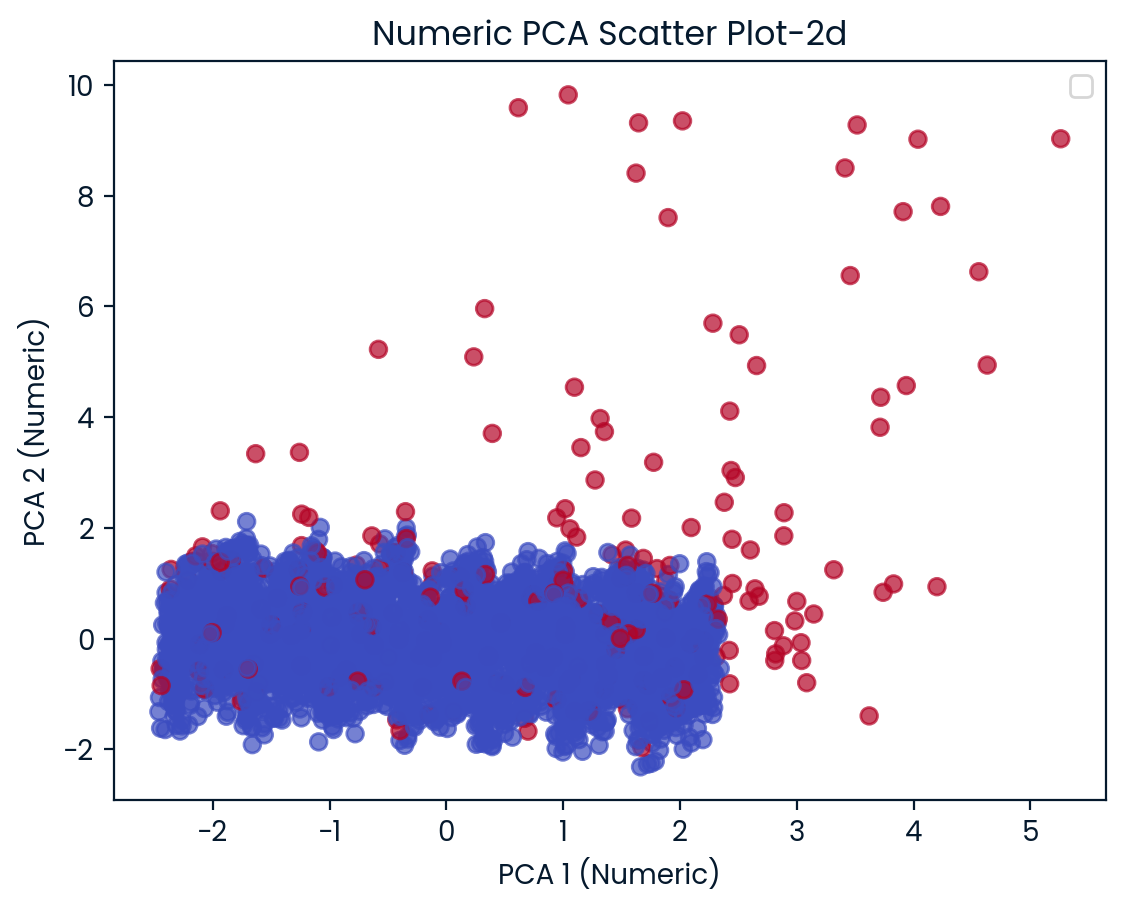

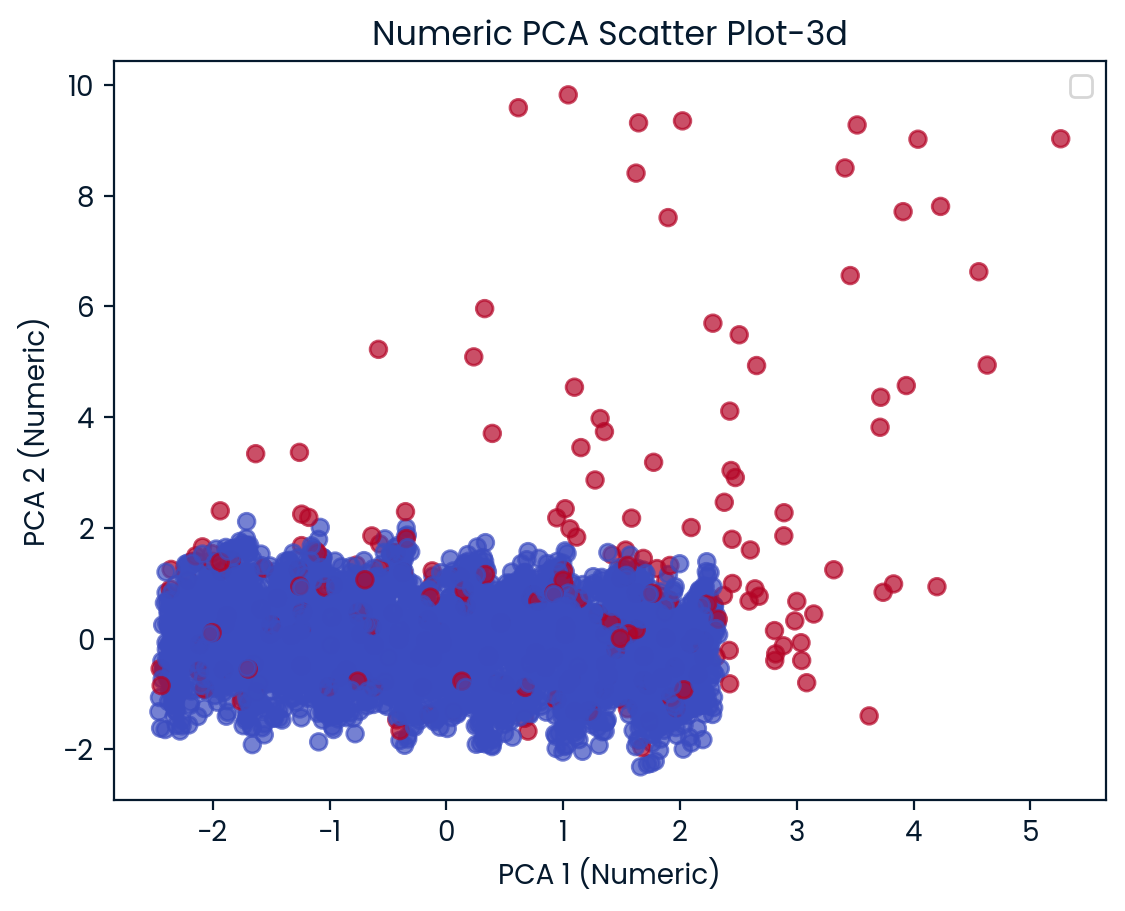

In [21]:
# plot numeric PCA 2D

plt.scatter(x_processed[:, 0], x_processed[:, 1], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('PCA 1 (Numeric)')
plt.ylabel('PCA 2 (Numeric)')
plt.title('Numeric PCA Scatter Plot-2d')
plt.legend()
plt.show()

# plot numeric PCA 3D
plt.scatter(x_processed_1[:, 0], x_processed_1[:, 1], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('PCA 1 (Numeric)')
plt.ylabel('PCA 2 (Numeric)')
plt.title('Numeric PCA Scatter Plot-3d')
plt.legend()
plt.show()

## Visualize Category SVD only

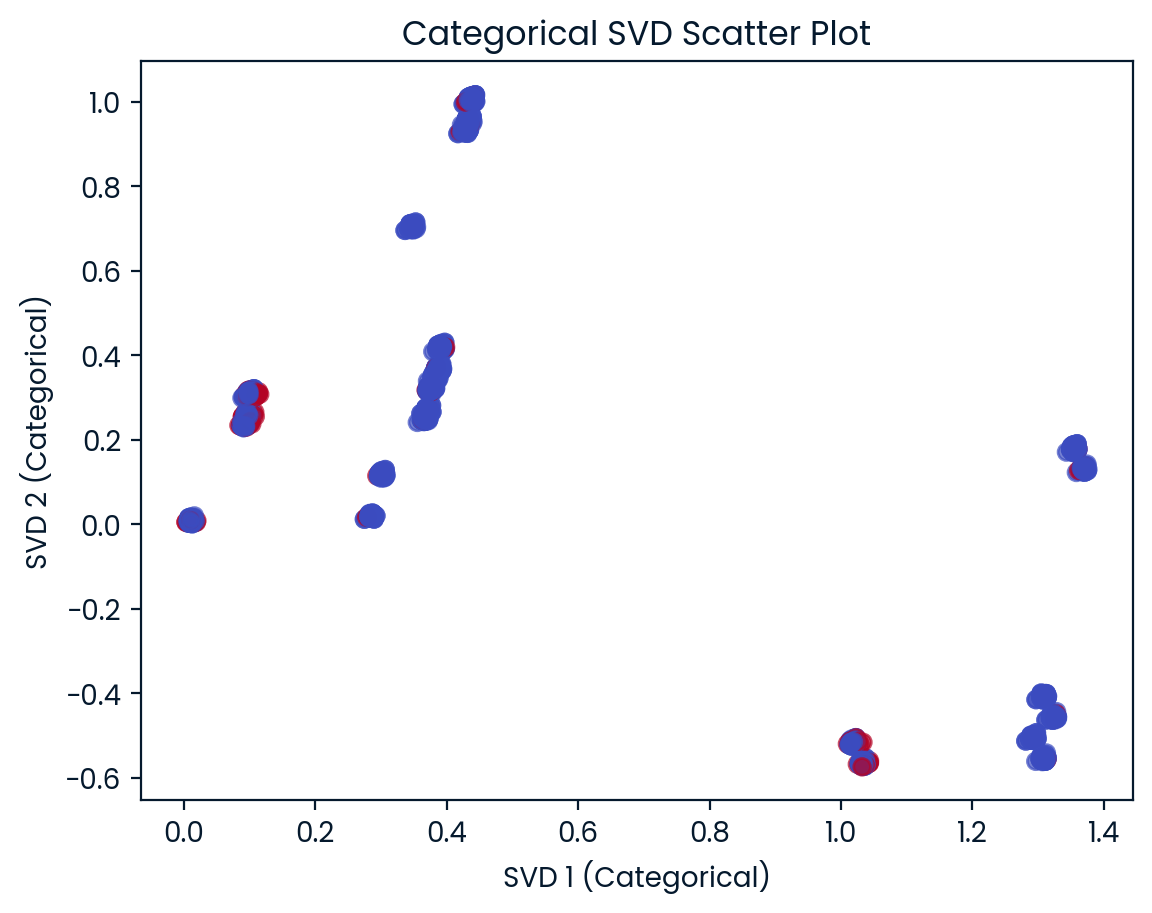

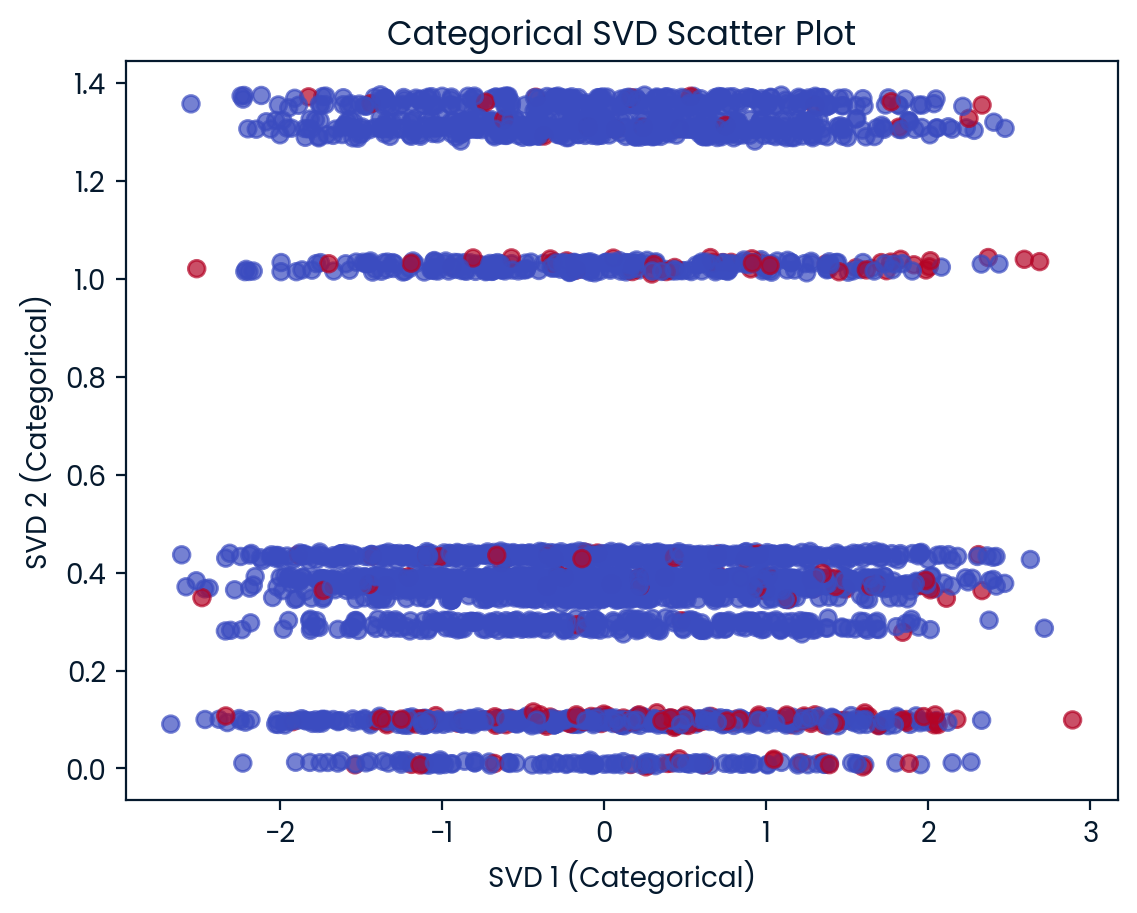

In [22]:
#plot SVD 2D
plt.scatter(x_processed[:, 2], x_processed[:, 3], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('SVD 1 (Categorical)')
plt.ylabel('SVD 2 (Categorical)')
plt.title('Categorical SVD Scatter Plot')
plt.show()

#plot SVD 3D
plt.scatter(x_processed_1[:, 2], x_processed_1[:, 3], c=(y_train == 'Yes'), cmap='coolwarm', alpha=0.7)
plt.xlabel('SVD 1 (Categorical)')
plt.ylabel('SVD 2 (Categorical)')
plt.title('Categorical SVD Scatter Plot')
plt.show()

## Step 4 : Fit the training and test data to the model

## Decision Tree Classifier

### Initiate base DTC model

Decision Tree untuned training score 1.0
Decision Tree untuned test score 0.978 



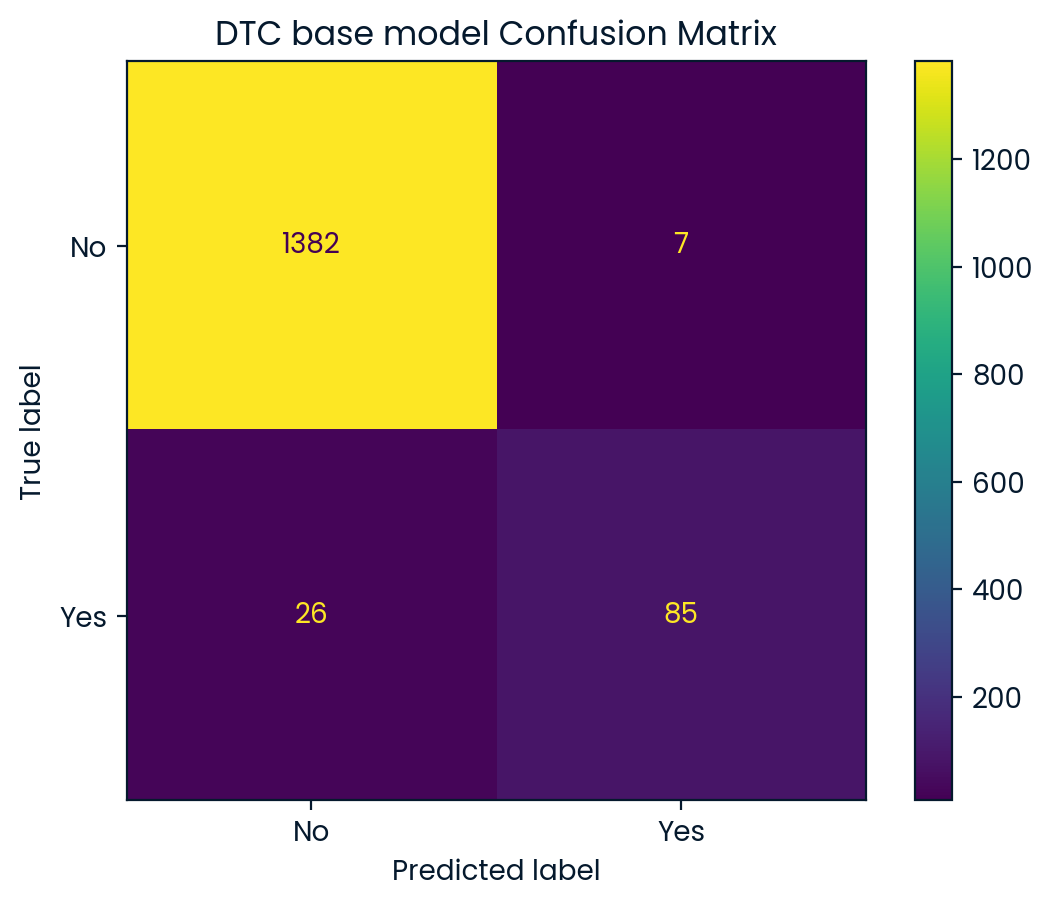

              precision    recall  f1-score   support

          No       0.98      0.99      0.99      1389
         Yes       0.92      0.77      0.84       111

    accuracy                           0.98      1500
   macro avg       0.95      0.88      0.91      1500
weighted avg       0.98      0.98      0.98      1500

1500
1500
CV train accuracy mean:0.980857142857143


In [23]:
# Connect pipeline to the model for Decision Tree
pipe_dtc = Pipeline([('pipe', preprocessor), ('model', DecisionTreeClassifier(random_state=42,class_weight='balanced'))])

# fit to the raw model
base_dtc_model = pipe_dtc.fit(X_train, y_train)

print(f'Decision Tree untuned training score {pipe_dtc.score(X_train, y_train)}')
print(f'Decision Tree untuned test score {pipe_dtc.score(X_test, y_test)}','\n')

# predict
base_dtc_model_y_pred =base_dtc_model.predict(X_test)

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, base_dtc_model_y_pred)
plt.title('DTC base model Confusion Matrix')
plt.show()

# classification report
print(classification_report(y_test, base_dtc_model_y_pred ))

print(len(X_test))
print(len(y_test))


# evaluate the cross validated performance on training data
cv_scores = cross_val_score(base_dtc_model, X_train,y_train,cv=5, scoring='accuracy')

# train accuracy
train_accuracy = base_dtc_model.score(X_train,y_train)

# test accuracy
test_accuracy =base_dtc_model.score(X_test,y_test)

# print the results
print(f'CV train accuracy mean:{np.mean(cv_scores)}')

## Step 5 : Hyperparameter tuned Decision Tree Classifier model to reduce the overfitting

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Decision Tree tuned training score 0.9817142857142858
Decision Tree tuned test score 0.974


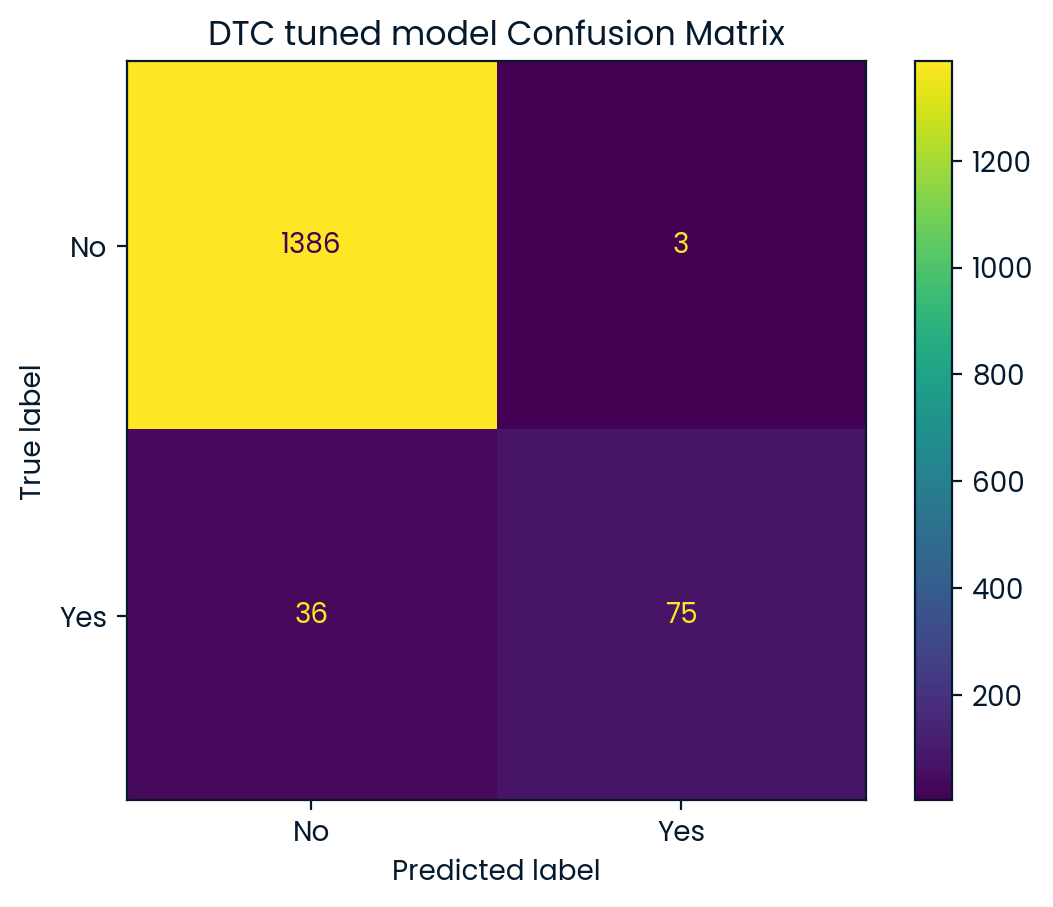

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      1389
         Yes       0.96      0.68      0.79       111

    accuracy                           0.97      1500
   macro avg       0.97      0.84      0.89      1500
weighted avg       0.97      0.97      0.97      1500

The accuracy score of tuned dtc model is : 0.974
0.980857142857143
{'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}


In [24]:
# set the parameters
param_grid = {
    'model__max_depth': [3, 5,7, None],
    'model__min_samples_split': [2, 3,5,10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy'] 
}

# grid search for optimal parameter
dtc_model_selected = GridSearchCV(estimator=pipe_dtc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# fit the data to the model
dtc_model_selected.fit(X_train, y_train)

# predict
dtc_y_pred = dtc_model_selected.predict(X_test)

print(f'Decision Tree tuned training score {dtc_model_selected.score(X_train, y_train)}')
print(f'Decision Tree tuned test score {accuracy_score(y_test, dtc_y_pred)}')

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, dtc_y_pred)
plt.title('DTC tuned model Confusion Matrix')
plt.show()

# classification report
print(classification_report(y_test, dtc_y_pred))

# accuracy score
print(f'The accuracy score of tuned dtc model is : {accuracy_score(y_test,dtc_y_pred)}')

# extract the best estimator
print(dtc_model_selected.best_score_)


# extract the best parameters
print(dtc_model_selected.best_params_)


## Step 6 : Finding the top feature importances in Decision Tree Classifier

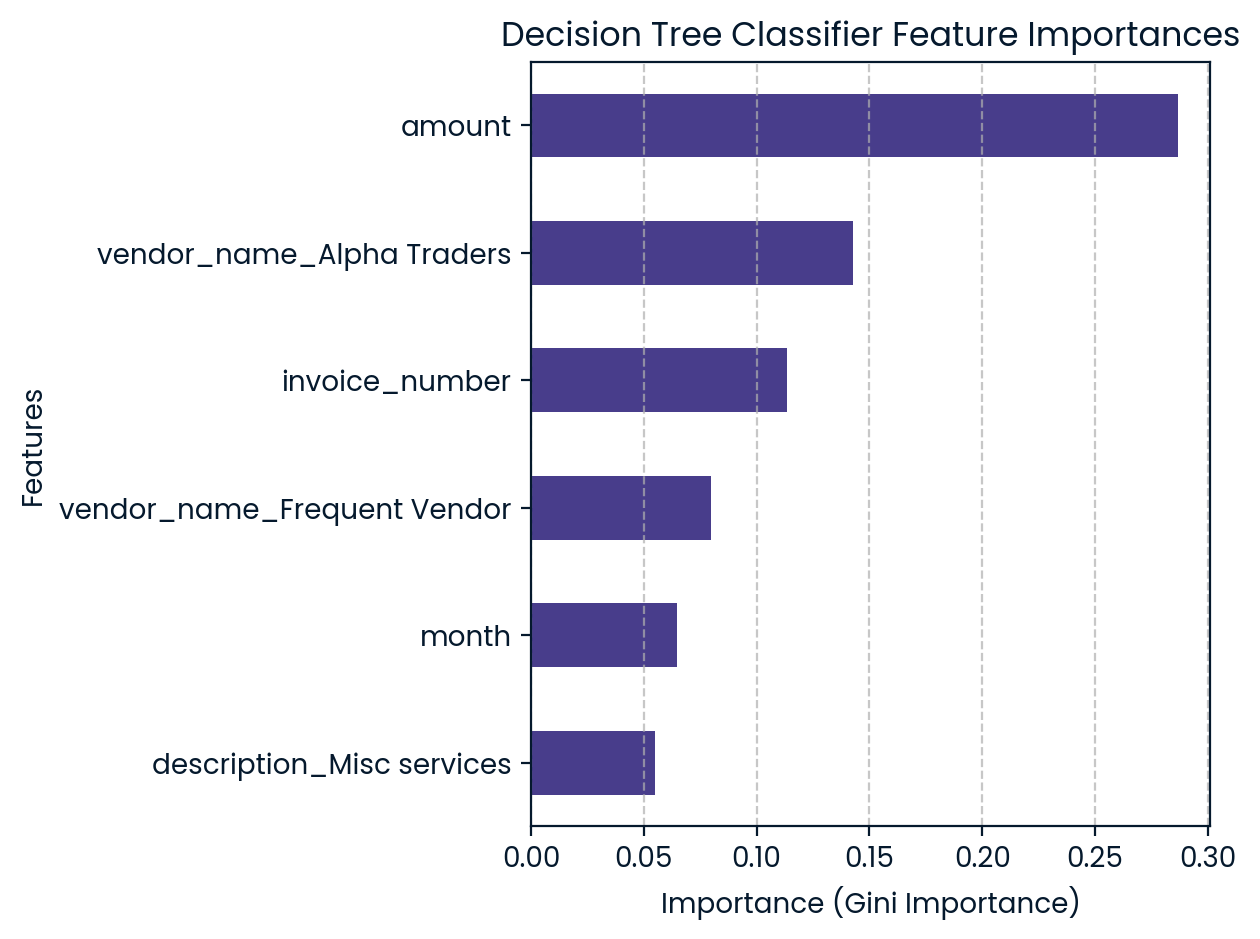

In [25]:
# Access the model from the pipeline using named_steps
dtc_model_pipeline = base_dtc_model.named_steps['model']

# Access the feature importance
dtc_feature_importance = dtc_model_pipeline.feature_importances_

# Access the preprocessor (cuz the arrays from the feature_importances are from prepocessed results)
fitted_processor = base_dtc_model.named_steps['pipe']

# convert numeric columns to list (no need as we store that in list already before creating X/feature)
num_features

# get encoded columns name
one_hot_encoded_names = fitted_processor.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()

# combined all the processed feature names
all_processed_feature_names = num_features + one_hot_encoded_names

# create pandas series
feature_importance_series = pd.Series(dtc_feature_importance, index=all_processed_feature_names).sort_values(ascending=False)
feature_importance_series_top = feature_importance_series[feature_importance_series >= 0.05]

feature_importance_series_top.plot(kind='barh', color='darkslateblue')
plt.title('Decision Tree Classifier Feature Importances')
plt.xlabel('Importance (Gini Importance)')
plt.ylabel('Features')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()



## Step 6 : Running base DTC model using only the top features

Decision Tree untuned training score 1.0
Decision Tree untuned test score 0.968 



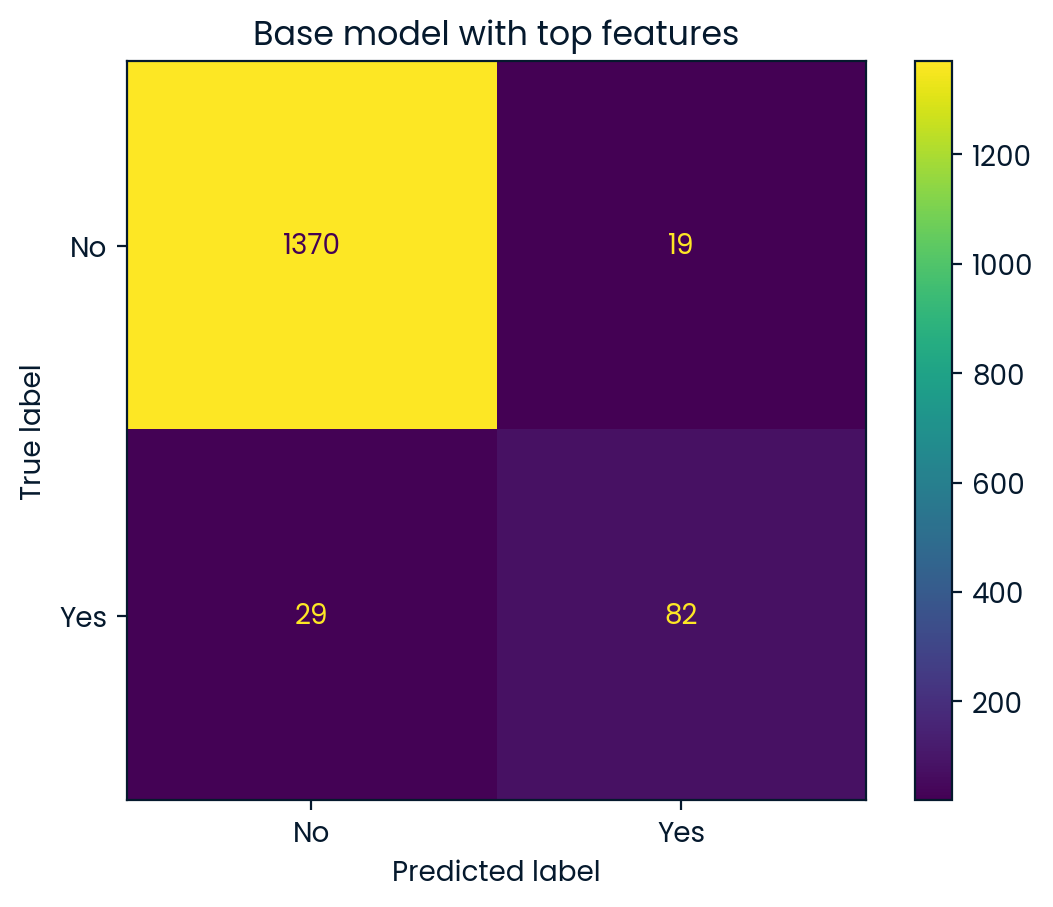

              precision    recall  f1-score   support

          No       0.98      0.99      0.98      1389
         Yes       0.81      0.74      0.77       111

    accuracy                           0.97      1500
   macro avg       0.90      0.86      0.88      1500
weighted avg       0.97      0.97      0.97      1500

1500
1500
CV train accuracy mean:0.976


In [26]:
#### Preprocessing 
# copy the data frame
df_1= df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
df_1['invoice_number'] = df_1['invoice_number'].str.extract(r'(\d+)')
df_1['invoice_number'] = df_1['invoice_number'].replace(np.nan,0)
df_1['invoice_number'] = df_1['invoice_number'].astype('int64')



# # extract date,month,year from the transaction_date and drop the transactio_date
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

df_1['hour'] = df_1['transaction_date'].dt.hour
df_1['day'] = df_1['transaction_date'].dt.day
df_1['month'] = df_1['transaction_date'].dt.month
df_1['year'] = df_1['transaction_date'].dt.year

df_1['dayofweek'] = df_1['transaction_date'].dt.dayofweek
df_1['is_weekend'] = df_1['dayofweek'].isin([5,6]).astype(int)
df_1.drop('transaction_date',axis=1,inplace=True)

# cast as category for the days of week and is_weekend
df_1['dayofweek'] = df_1['dayofweek'].astype('category')
df_1['is_weekend'] = df_1['is_weekend'].astype('category')

# split features by type
num_features =['invoice_number','amount','month']
cat_features = ['vendor_name','description']

# Features and target for train data
X = df_1[num_features + cat_features]
y = df_1['fraud']

# train, test, split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state =42)

# Preprocessing pipeline
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

cat_pipeline = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='ignore'))])

preprocessor =ColumnTransformer([('num',num_pipeline, num_features),('cat',cat_pipeline,cat_features)])


# Connect pipeline to the model for Decision Tree
pipe_dtc = Pipeline([('pipe', preprocessor), ('model', DecisionTreeClassifier(random_state=42,class_weight='balanced'))])

# fit to the raw model
base_dtc_model = pipe_dtc.fit(X_train, y_train)

print(f'Decision Tree untuned training score {pipe_dtc.score(X_train, y_train)}')
print(f'Decision Tree untuned test score {pipe_dtc.score(X_test, y_test)}','\n')

# predict
base_dtc_model_y_pred =base_dtc_model.predict(X_test)

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, base_dtc_model_y_pred)
plt.title('Base model with top features')
plt.show()

# classification report
print(classification_report(y_test, base_dtc_model_y_pred ))

print(len(X_test))
print(len(y_test))


# evaluate the cross validated performance on training data
cv_scores = cross_val_score(base_dtc_model, X_train,y_train,cv=5, scoring='accuracy')

# train accuracy
train_accuracy = base_dtc_model.score(X_train,y_train)

# test accuracy
test_accuracy =base_dtc_model.score(X_test,y_test)

# print the results
print(f'CV train accuracy mean:{np.mean(cv_scores)}')


## Step 6: Rerunning the tuned model with top features

Decision Tree tuned training score 0.9817142857142858
Decision Tree tuned test score 0.9753333333333334


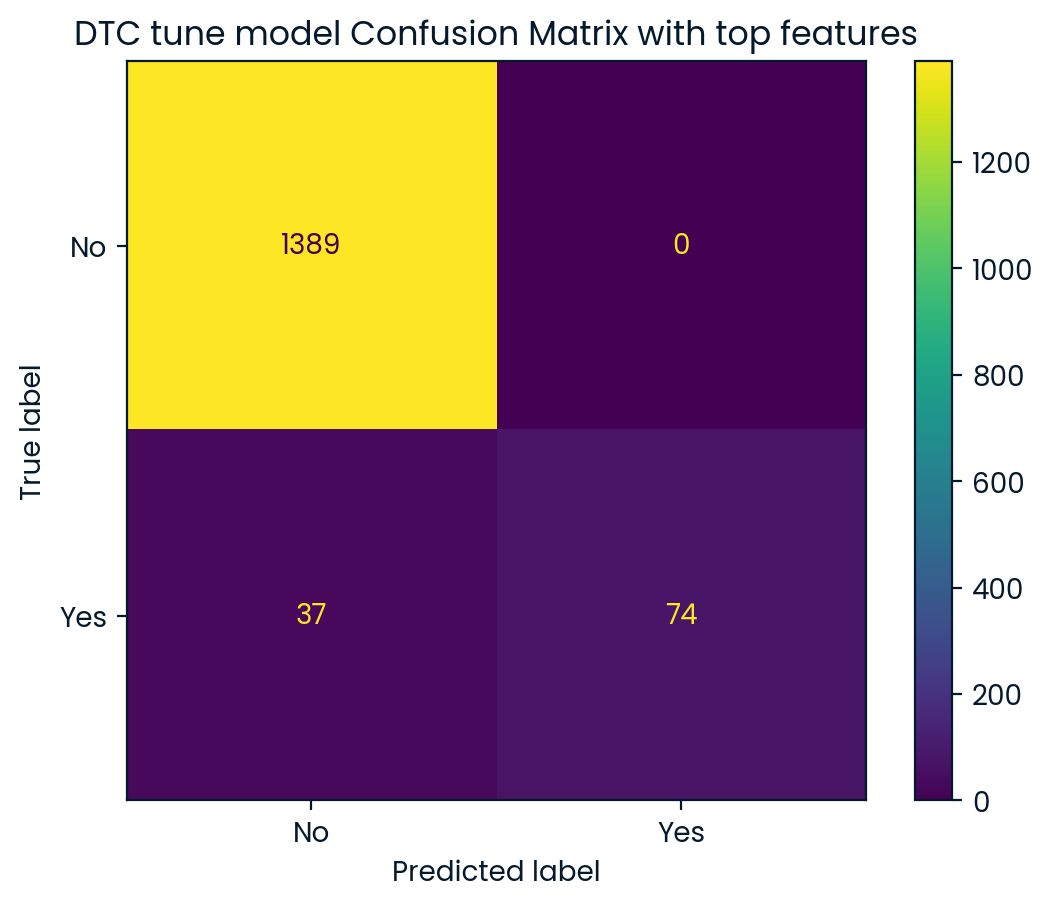

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      1389
         Yes       1.00      0.67      0.80       111

    accuracy                           0.98      1500
   macro avg       0.99      0.83      0.89      1500
weighted avg       0.98      0.98      0.97      1500

The accuracy score of tuned dtc model is : 0.9753333333333334


In [27]:
#### Preprocessing 
# copy the data frame
df_1= df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
df_1['invoice_number'] = df_1['invoice_number'].str.extract(r'(\d+)')
df_1['invoice_number'] = df_1['invoice_number'].replace(np.nan,0)
df_1['invoice_number'] = df_1['invoice_number'].astype('int64')

# # extract date,month,year from the transaction_date and drop the transactio_date
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

df_1['hour'] = df_1['transaction_date'].dt.hour
df_1['day'] = df_1['transaction_date'].dt.day
df_1['month'] = df_1['transaction_date'].dt.month
df_1['year'] = df_1['transaction_date'].dt.year

df_1['dayofweek'] = df_1['transaction_date'].dt.dayofweek
df_1['is_weekend'] = df_1['dayofweek'].isin([5,6]).astype(int)
df_1.drop('transaction_date',axis=1,inplace=True)

# cast as category for the days of week and is_weekend
df_1['dayofweek'] = df_1['dayofweek'].astype('category')
df_1['is_weekend'] = df_1['is_weekend'].astype('category')

# split features by type
num_features =['invoice_number','amount','month']
cat_features = ['vendor_name','description']

# Features and target for train data
X = df_1[num_features + cat_features]
y = df_1['fraud']

# train, test, split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state =42)

# Preprocessing pipeline
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

cat_pipeline = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='ignore'))])

preprocessor =ColumnTransformer([('num',num_pipeline, num_features),('cat',cat_pipeline,cat_features)], remainder='passthrough')


# Connect pipeline to the model for Decision Tree
dtc_model = Pipeline([('pipe', preprocessor), ('model', DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1,min_samples_split=5,random_state=42,class_weight='balanced'))])


# fit the data to the model
dtc_model.fit(X_train, y_train)

# predict
dtc_y_pred = dtc_model.predict(X_test)

print(f'Decision Tree tuned training score {dtc_model.score(X_train, y_train)}')
print(f'Decision Tree tuned test score {accuracy_score(y_test, dtc_y_pred)}')

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, dtc_y_pred)
plt.title('DTC tune model Confusion Matrix with top features')
plt.show()

# classification report
print(classification_report(y_test, dtc_y_pred))

# accuracy score
print(f'The accuracy score of tuned dtc model is : {accuracy_score(y_test,dtc_y_pred)}')


## Extract the transaction that are not caught by the ML model

In [28]:
# reassemble the df in new varaible
result = X_test.copy()
result['actual'] = y_test
result['predicted'] = dtc_y_pred
result.reset_index()

# filter the rows where actual dont equal predicted
false_negative = result.loc[(result['actual'] =='Yes') & (result['predicted'] =='No') ]
false_positive = result.loc[(result['actual'] =='No') & (result['predicted'] =='Yes') ]

# inner join with original data set using index
false_negative_df = false_negative.merge(df['fraud_type'],left_index=True,right_index=True)
false_negative_df

true_positive = result.loc[(result['actual'] =='Yes') & (result['predicted'] =='Yes') ]
true_positive_df = true_positive.merge(df['fraud_type'],left_index=True,right_index=True)
true_positive_df

,invoice_number,amount,month,vendor_name,description,actual,predicted,fraud_type
4635,8043,105.790000,12,Alpha Traders,Misc services,Yes,Yes,Vague Description | Transaction logged by inva...
199,7735,254.077000,1,Alpha Traders,Misc services,Yes,Yes,Vague Description | Slightly unusual amount
4445,7474,2000.000000,7,Global Goods,Procurement of repair and maintenance,Yes,Yes,Suspicious round number
2847,0,300.000000,4,"Bennett, Smith and Leblanc",Expense for electricity bill,Yes,Yes,Vendor with high amount | Vendor/Employee beha...
1128,0,2000.000000,2,Smith LLC,Invoice for legal advisory,Yes,Yes,Duplicate Invoices | Missing PO | Suspicious r...
...,...,...,...,...,...,...,...,...
1891,7229,200.993585,12,Tech Supplies,Reimbursement for repair and maintenance,Yes,Yes,Vendor with high amount | Slightly unusual amo...
1519,9275,93.950000,12,"Reed, Miller and Sanders",Misc services,Yes,Yes,Vague Description | Invalid Approver | Duplica...
2409,3527,204.057000,4,Shaw Group,Invoice for marketing services,Yes,Yes,Vendor/Employee behavior deviation | Slightly ...
4718,6992,111.720000,7,Mathews and Sons,Misc services,Yes,Yes,Vague Description | Multiple factors | Unusual...


## Step 4 : Initiating Base Random Tree Forest model

Random Tree Classifer untuned training score 1.0
Random Tree Classifer untuned test score 0.978 



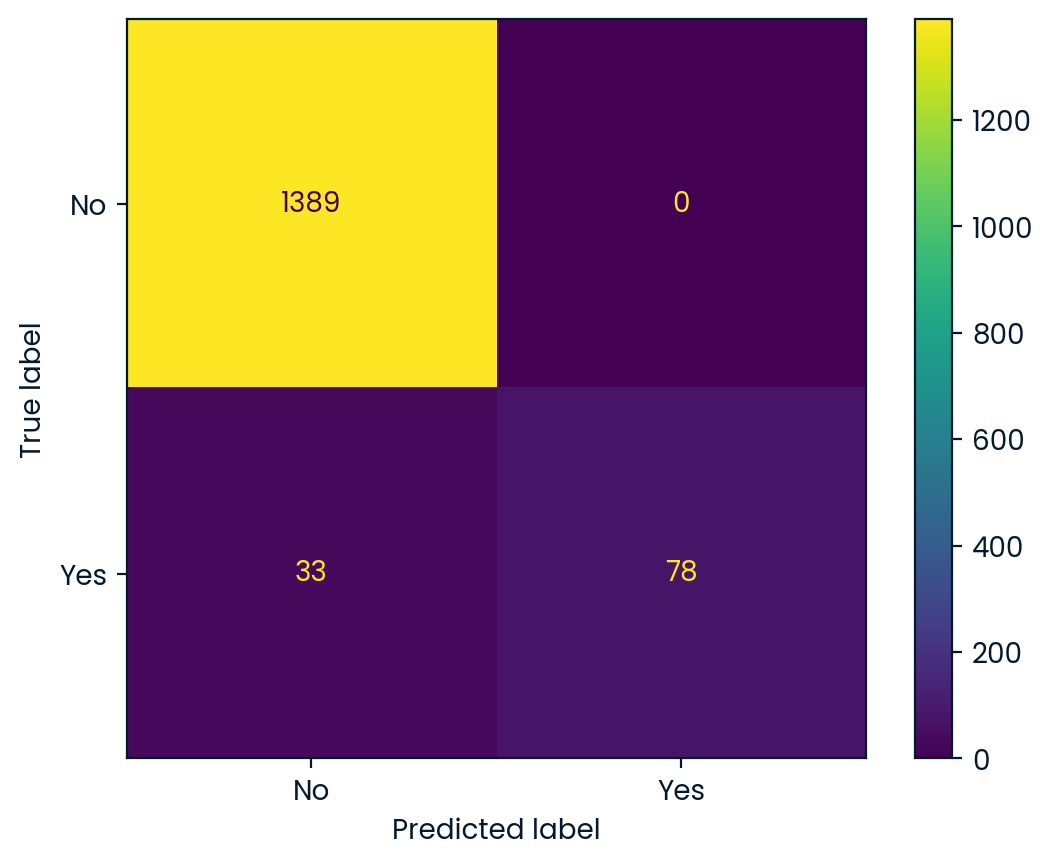

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      1389
         Yes       1.00      0.70      0.83       111

    accuracy                           0.98      1500
   macro avg       0.99      0.85      0.91      1500
weighted avg       0.98      0.98      0.98      1500

1500
1500
CV train accuracy mean:0.9814285714285715
Train accuracy 1.0
Test accuracy 0.978
Generalization gap= 0.02200000000000002


In [29]:
pipe_rfc = Pipeline([('pipe', preprocessor), 
                     ('model', RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'))])

# fit to the raw model
base_rfc_model = pipe_rfc.fit(X_train, y_train)

print(f'Random Tree Classifer untuned training score {pipe_rfc.score(X_train, y_train)}')
print(f'Random Tree Classifer untuned test score {pipe_rfc.score(X_test, y_test)}','\n')

# predict
base_rfc_model_y_pred =base_rfc_model.predict(X_test)

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, base_rfc_model_y_pred)
plt.show()

# classification report
print(classification_report(y_test, base_rfc_model_y_pred ))

print(len(X_test))
print(len(y_test))


# evaluate the cross validated performance on training data
cv_scores = cross_val_score(base_rfc_model, X_train,y_train,cv=5, scoring='accuracy')

# train accuracy
train_accuracy = base_rfc_model.score(X_train,y_train)

# test accuracy
test_accuracy =base_rfc_model.score(X_test,y_test)

# print the results
print(f'CV train accuracy mean:{np.mean(cv_scores)}')
print(f'Train accuracy {train_accuracy}')
print(f'Test accuracy {test_accuracy}')
print(f'Generalization gap= {train_accuracy-test_accuracy}')

## Step 5 : Hyper paramtere tuned the Random Tree Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Tree Forest tuned training score 0.992
Random Tree Forest tuned test score 0.9726666666666667
CV train accuracy mean:0.9814285714285715


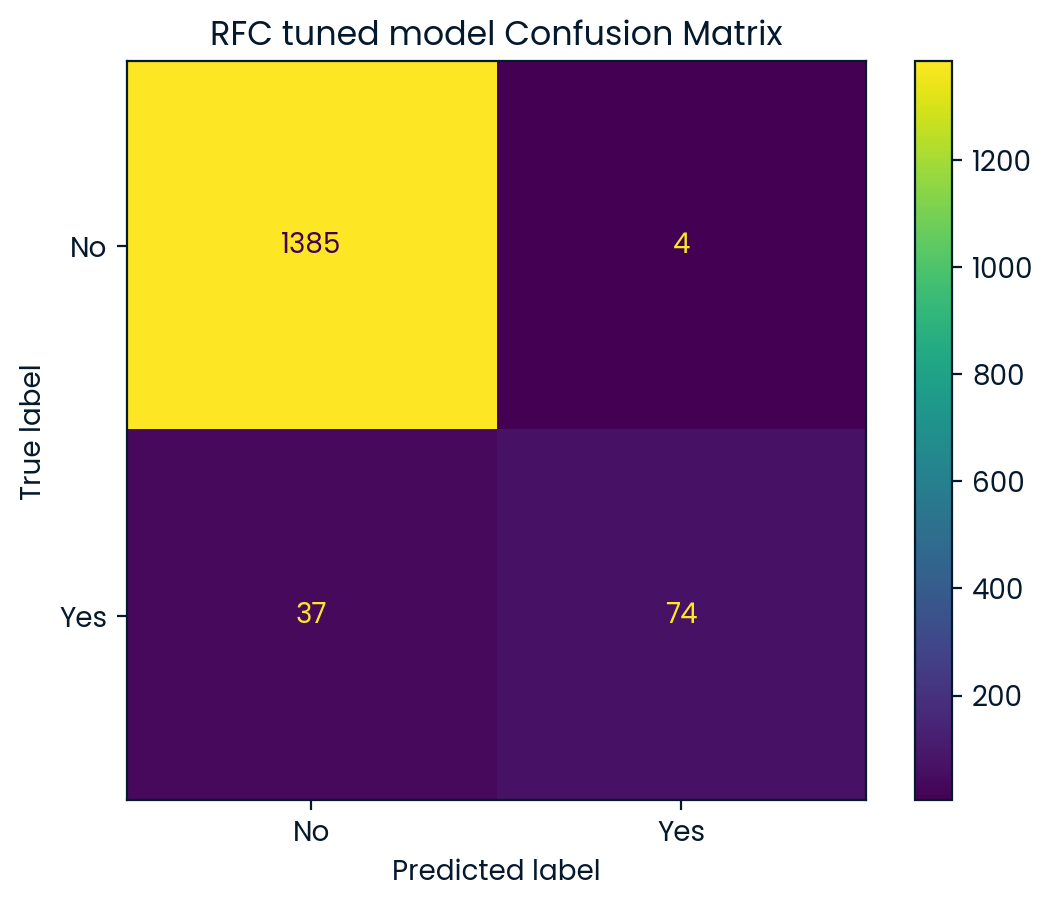

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      1389
         Yes       0.95      0.67      0.78       111

    accuracy                           0.97      1500
   macro avg       0.96      0.83      0.88      1500
weighted avg       0.97      0.97      0.97      1500

The accuracy score of tuned rtf model is : 0.9726666666666667
0.9814285714285713
{'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': False}


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False]
}

pipe_rfc = Pipeline([('pipe', preprocessor), 
                     ('model', RandomForestClassifier(n_estimators=100, random_state=42,class_weight={'No': 1, 'Yes': 10}))])



# grid search for optimal parameter
rtf_model = RandomizedSearchCV(estimator=pipe_rfc,  param_distributions=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

# fit the data to the model
rtf_model.fit(X_train, y_train)

# predict
rtf_y_pred = rtf_model.predict(X_test)

print(f'Random Tree Forest tuned training score {rtf_model.score(X_train, y_train)}')
print(f'Random Tree Forest tuned test score {accuracy_score(y_test, rtf_y_pred)}')

# evaluate the cross validated performance on training data
cv_scores = cross_val_score(base_rfc_model, X_train,y_train,cv=5, scoring='accuracy')

# print the results
print(f'CV train accuracy mean:{np.mean(cv_scores)}')

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, rtf_y_pred)
plt.title('RFC tuned model Confusion Matrix')
plt.show()

# classification report
print(classification_report(y_test, rtf_y_pred))

# accuracy score
print(f'The accuracy score of tuned rtf model is : {accuracy_score(y_test, rtf_y_pred)}')

# extract the best estimator
print(rtf_model.best_score_)

# extract the best parameters
print(rtf_model.best_params_)

[[  34 1355]
 [   2  109]]
              precision    recall  f1-score   support

          No       0.94      0.02      0.05      1389
         Yes       0.07      0.98      0.14       111

    accuracy                           0.10      1500
   macro avg       0.51      0.50      0.09      1500
weighted avg       0.88      0.10      0.05      1500



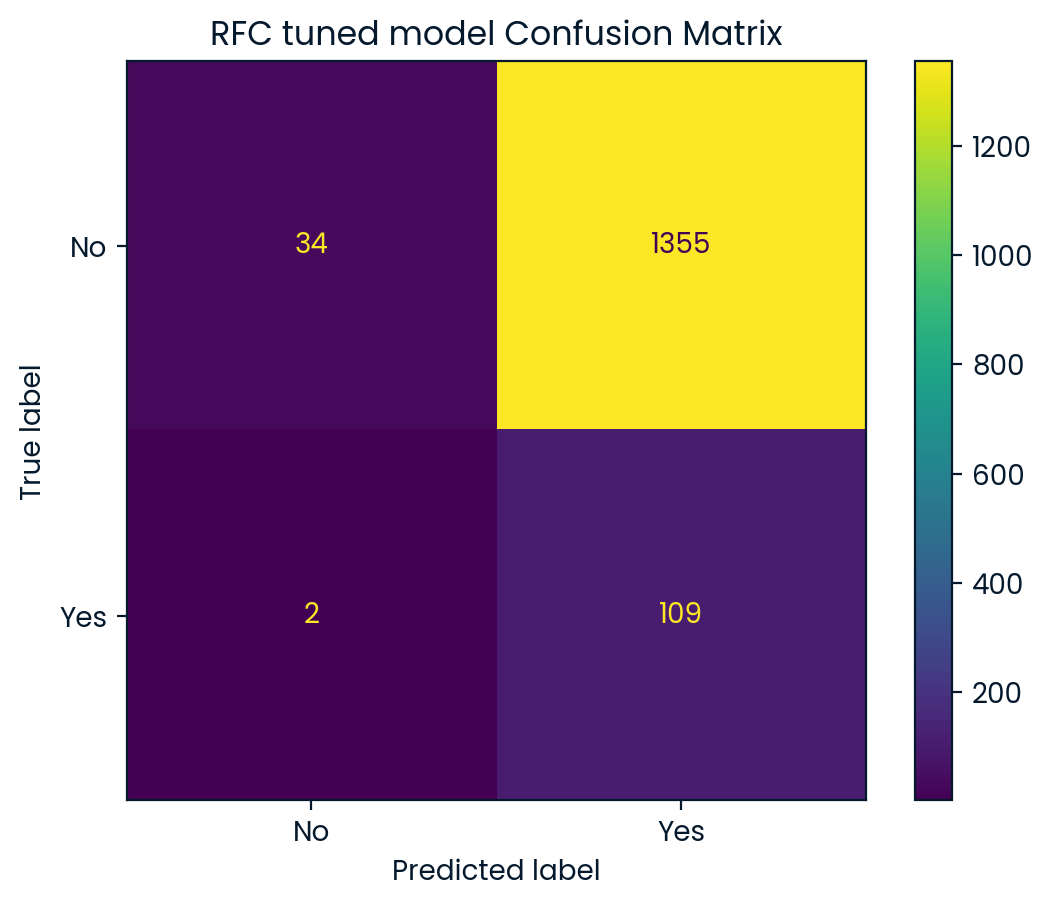

Train accuracy: 0.9765714285714285
Test accuracy: 0.9686666666666667


In [31]:
#  Add class_weight to your RFC
rfc = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight={ 'No': 1, 'Yes': 10 },   # heavier penalty for missing 'Yes'
    random_state=42
)

pipe_rfc = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rfc)
])

# Train as usual
pipe_rfc.fit(X_train, y_train)

# Get probabilities
y_proba = pipe_rfc.predict_proba(X_test)[:, 1]  # prob that it is fraud (Yes)

#  Try a *lower* threshold — say 0.3 instead of 0.5
threshold = 0.3
y_pred = (y_proba >= threshold).astype('object')
y_pred[y_pred == 1] = 'Yes'
y_pred[y_pred == 0] = 'No'

#  Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('RFC tuned model Confusion Matrix')
plt.show()

print(f"Train accuracy: {pipe_rfc.score(X_train, y_train)}")
print(f"Test accuracy: {pipe_rfc.score(X_test, y_test)}")

# Phase 3

# Refined approach to the project
1. Generate a synthetic data set again
2. Flagged the transactions using the rules based approach
3. Pass the flagged transactions to trained ML model
4. Block and review those transactions flagged as fraud by ML model
5. Ligh investigation on the remaining transactions not flagged as fraud by ML model

## Step 1: Create a synthetic testing data set again

In [32]:
# import relevant features
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from faker import Faker
import random

# Initialize Faker
faker = Faker()
np.random.seed(45)
random.seed(45)

# Dataset size
n_transactions = 3500

# Base DataFrame with base columns
df = pd.DataFrame({
    'transaction_id': np.arange(1, n_transactions + 1),
    'transaction_date': pd.date_range(start='2024-01-01', periods=n_transactions, freq='H'),
    'employee_id': np.random.choice(range(1500, 1515), n_transactions),
    'vendor_name': np.random.choice(
        ['James LLC', 'Power House Tech', 'Elite Brother Supplies', 'Super Sun'], n_transactions),
    'approved_by': [faker.name() for _ in range(n_transactions)],
    'invoice_number': ['INV-' + str(random.randint(2000, 11000)) for i in range(n_transactions)],
    'amount': np.random.normal(loc=150, scale=35, size=n_transactions).round(2),
    'fraud': 'No',
    'fraud_type': ''
})

# Add realistic expense descriptions using Faker
def generate_description():
    expense_items = [
        'diesel fuel',
        'office supplies',
        'marketing services',
        'consulting fees',
        'IT hardware',
        'repair and maintenance',
        'electricity bill',
        'legal advisory',
        'travel reimbursement',
        'stationery',
        'software license',
        'staff training',
        'warehouse rental'
    ]
    actions = [
        'Purchase of',
        'Payment for',
        'Reimbursement for',
        'Consulting for',
        'Service fee for',
        'Expense for',
        'Procurement of',
        'Invoice for'
    ]
    return f"{faker.random_element(actions)} {faker.random_element(expense_items)}"

df['description'] = [generate_description() for i in range(len(df))]

# Compute vendor average for context
vendor_avg = df.groupby('vendor_name')['amount'].mean().to_dict()

# Pick ~5–8% random transactions for fraud
fraud_pct = 0.05
n_frauds = int(fraud_pct * n_transactions)
fraud_indices = np.random.choice(df.index, n_frauds, replace=False)

laid_off_employees = [1501, 1509]
laid_off_date = pd.Timestamp('2024-02-01')

# Inject frauds
for i in fraud_indices:
    fraud_flags = []

    # Subtle Frauds
    if np.random.rand() < 0.5:
        if np.random.rand() < 0.8:
            df.loc[i, 'amount'] *= 1.05
        else:
            df.loc[i, 'amount'] *= 2.05
        fraud_flags.append('Slightly unusual amount')

    if np.random.rand() < 0.4:
        if np.random.rand() < 0.5:
            df.loc[i, 'transaction_date'] = df.loc[i, 'transaction_date'].replace(
                hour=random.choice([20,21,22,23])
            )
        else:
            df.loc[i, 'transaction_date'] = pd.Timestamp('2024-12-22') + pd.Timedelta(
                hours=random.randint(0, 23)
            )
        fraud_flags.append('Unusual timing patterns')

    if np.random.rand() < 0.3:
        df.loc[i, 'vendor_name'] = faker.company()
        fraud_flags.append('Vendor/Employee behavior deviation')

    if np.random.rand() < 0.1:
        df.loc[i, 'amount'] *= 1.05
        df.loc[i, 'transaction_date'] = df.loc[i, 'transaction_date'].replace(
            hour=random.choice([0, 1, 2, 3, 4, 23])
        )
        df.loc[i, 'vendor_name'] = faker.company()
        fraud_flags.append('Multiple factors')

    if np.random.rand() < 0.1:
        df.loc[i, 'description'] = 'Misc services'
        fraud_flags.append('Vague Description')

    # Straightforward Frauds
    vendor = df.loc[i, 'vendor_name']
    if np.random.rand() < 0.2:
        df.loc[i, 'amount'] = vendor_avg.get(vendor, 100) * np.random.choice([2, 3])
        fraud_flags.append('Vendor with high amount')

    if np.random.rand() < 0.2:
        df.loc[i, 'approved_by'] = faker.name() + ' (Invalid)'
        fraud_flags.append('Invalid Approver')

    if df.loc[i, 'employee_id'] in laid_off_employees and df.loc[i, 'transaction_date'] > laid_off_date:
        fraud_flags.append('Transaction logged by invalid employee')

    if np.random.rand() < 0.2:
        duplicate_idx = random.choice(df.index)
        df.loc[i, 'invoice_number'] = df.loc[duplicate_idx, 'invoice_number']
        fraud_flags.append('Duplicate Invoices')

    if np.random.rand() < 0.2:
        df.loc[i, 'amount'] = np.random.choice([1000, 2000, 5000, 10000])
        fraud_flags.append('Suspicious round number')

    if np.random.rand() < 0.2:
        df.loc[i, 'vendor_name'] = 'Frequent Vendor'
        fraud_flags.append('Same vendor used by more than 2 or 3 employees')

    if np.random.rand() < 0.2:
        df.loc[i, 'invoice_number'] = None
        fraud_flags.append('Missing PO')

    # Final flagging
    if fraud_flags:
        df.loc[i, 'fraud'] = 'Yes'
        df.loc[i, 'fraud_type'] = ' | '.join(set(fraud_flags))

# Check fraud balance
print(df['fraud'].value_counts(normalize=True))

fraud
No     0.951714
Yes    0.048286
Name: proportion, dtype: float64


## Step 2 : Flagged the transactions using the rules based approach

In [33]:
def detect_fraud_rules(df):
    """
    Rule-based detection: tag fraud type(s) based on your injection logic.
    Works on the entire DataFrame.
    Adds/overwrites columns: fraud_flag (Yes/No) and fraud_type_detected.
    """
    detected_flags = []
    detected_types = []

    # Get vendor average for fresh check
    vendor_avg = df.groupby('vendor_name')['amount'].mean().to_dict()
    laid_off_employees = [1501, 1509]
    laid_off_date = pd.Timestamp('2024-02-01')

    for idx, row in df.iterrows():
        flags = []

        #Slightly unusual amount: amount slightly higher than vendor avg
        if row['vendor_name'] in vendor_avg: # check if the vendor name is in the vendor_avg dict 
            if vendor_avg[row['vendor_name']] > 0: # get the value of selected vendor and check if exist
                ratio = row['amount'] / vendor_avg[row['vendor_name']]
                # find if ratio amt:vendor's avg amt falls between 1.04 and 1.099
                if 1.07 < ratio < 1.9:
                    flags.append('Slightly high amount') # add to the empty list
                # if ratio is greater than 2
                elif ratio >= 2:
                    flags.append('Vendor with high amount')


        
        #Unusual timing: hours outside 6–22 or on unusual date
        if row['transaction_date'].hour >= 23 or row['transaction_date'].hour < 6: #
            flags.append('Unusual timing patterns')
        # Unusual timing : public holiday
        if row['transaction_date'].month == 12 and row['transaction_date'].day in [24, 25, 31]:
            flags.append('Unusual timing patterns')

        #Vendor/Employee behavior deviation: generic unknown vendor name
        if row['vendor_name'] not in ['James LLC', 'Power House Tech', 'Elite Brother Supplies', 'Super Sun', 'Frequent Vendor']:
            flags.append('Vendor/Employee behavior deviation')

        #Vague description: check simple keyword
        if 'Misc' in row['description']:
            flags.append('Vague Description')

        #Invalid approver: check for keyword
        if '(Invalid)' in row['approved_by']:
            flags.append('Invalid Approver')

        #Transaction logged by invalid employee
        if (row['employee_id'] in laid_off_employees) and (row['transaction_date'] > laid_off_date):
            flags.append('Transaction logged by invalid employee')

        #Duplicate Invoices: same invoice appears > 1 time
        inv_num = row['invoice_number']
        if pd.notna(inv_num):
             if df[df['invoice_number'] == inv_num]['vendor_name'].nunique() > 1:
                flags.append('Duplicate Invoices')

        # Suspicious round number: multiple of 1000
        if row['amount'] >= 5000 and row['amount'] % 1000 == 0:
            flags.append('Suspicious round number')

        #Same vendor used by multiple employees: vendor count > 2
        vendor = row['vendor_name']
        if vendor != 'Frequent Vendor':
            if df[df['vendor_name'] == vendor]['employee_id'].nunique() >= 3:
                flags.append('Same vendor used by more than 2 or 3 employees')

        #Missing PO: no invoice number or zero
        if pd.isna(row['invoice_number']) or row['invoice_number'] == 0:
            flags.append('Missing PO')

        if flags:
            detected_flags.append('Yes')
            detected_types.append(' | '.join(sorted(set(flags))))
        else:
            detected_flags.append('No')
            detected_types.append('')

    df['fraud_flag'] = detected_flags
    df['fraud_type_detected'] = detected_types

    return df

#Apply the function and store in variable
df_checked = detect_fraud_rules(df)

# Quick check
print(df_checked['fraud_flag'].value_counts(normalize=True))

# Filter the transactions flagged as fraud and store in in a variable
fraud_yes_df = df[df['fraud_flag'] == 'Yes']

fraud_flag
Yes    0.997714
No     0.002286
Name: proportion, dtype: float64


In [37]:
# Preprocess and pass the flagged transactions to the model
#### Preprocessing 
# copy the data frame
df_1= fraud_yes_df.copy()

## strip the INV- letter from the invoice_number column and cast as interger
df_1['invoice_number'] = df_1['invoice_number'].str.extract(r'(\d+)')
df_1['invoice_number'] = df_1['invoice_number'].replace(np.nan,0)
df_1['invoice_number'] = df_1['invoice_number'].astype('int64')



# # extract date,month,year from the transaction_date and drop the transactio_date
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

df_1['hour'] = df_1['transaction_date'].dt.hour
df_1['day'] = df_1['transaction_date'].dt.day
df_1['month'] = df_1['transaction_date'].dt.month
df_1['year'] = df_1['transaction_date'].dt.year

df_1['dayofweek'] = df_1['transaction_date'].dt.dayofweek
df_1['is_weekend'] = df_1['dayofweek'].isin([5,6]).astype(int)
df_1.drop('transaction_date',axis=1,inplace=True)

# cast as category for the days of week and is_weekend
df_1['dayofweek'] = df_1['dayofweek'].astype('category')
df_1['is_weekend'] = df_1['is_weekend'].astype('category')

# split features by type
num_features =['transaction_id','employee_id','invoice_number','amount','year','month','day','hour']
cat_features = ['vendor_name','description','approved_by','dayofweek','is_weekend']

# Features and target for train data
X = df_1[num_features + cat_features]
y = df_1['fraud']

# Preprocessing pipeline
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

cat_pipeline = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='ignore'))])

preprocessor =ColumnTransformer([('num',num_pipeline, num_features),('cat',cat_pipeline,cat_features)])

# Connect pipeline to the model for Decision Tree
# dtc_model = Pipeline([('pipe', preprocessor), ('model', DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1,min_samples_split=5,random_state=42,class_weight='balanced'))])

# # instantiate the model
# dtc_model.fit()

# predict
dtc_model_y_pred =dtc_model_selected.predict(X)

# add the predicted label to the data frame
df_1['predicted_label'] = dtc_model_y_pred

df_1['predicted_label'].value_counts()

predicted_label
No     2116
Yes    1376
Name: count, dtype: int64

# Conclusion

Initially when we used data that has only simple fraud pattern, CART model was memorizing well (overfitting) but poorly in predicting the fraud and generalizing. We didnt consider KNN and logistic regression model as fraud and legitimate transactions overlap. (Phase 1)

So, decided to test the model again while this time introducing subtle fraud to data set and see the performance of CART, where we noticed tuned DTC models works better by not overfitting. (Phase 2)

After the phase 1 and phase 2 test we decided to go with hybrid approach where we will flagged the transaction as 'Fraud or Legitimate' and noted alot of transactions (98%) were flagged as fraud, this is indication of high False Positive. We passed the prototype ML model to filter out the actual fraud from the flagged transactions where around 40% were flagged as fraud leaving 60% which still have fraud that is subtle for the ML model to differentiate. 